## 什么是PINN

物理信息神经网络(Physics-Informed Neural Networks, PINN) 是一种神经网络 (NNs)，它可以将模型方程(model equations，主要是非线性微分方程)编码为神经网络的一个组成部分，或者说物理信息神经网络是一种在遵守由一般非线性偏微分方程 (general nonlinear partial differential equations)描述的任何给定物理定律的同时，训练用于解决监督学习(supervised learning)任务的神经网络。物理信息神经网络的理论非常简单：在训练神经网络的时候，直接把已知的微分方程加入到损失函数中。PINN 可以在减少微分方程残差的同时，拟合观察数据，是一种多任务学习框架。从函数逼近论的角度来看，神经网络可以看作一个通用的非线性函数逼近器，而偏微分方程的建模过程也是寻找满足约束条件的非线性函数。

PINN解决了两类主要问题(就是PDE的正问题和求参的逆问题)：偏微分方程的数据驱动解和数据驱动发现(data-driven solution and data-driven discovery)。根据可用数据的性质和排列，有两类不同的算法，即连续时间模型和离散时间模型(continuous time and discrete time models)。第一类模型形成了一个新的数据高效的通用函数逼近器族(family of data-efficient spatio-temporal function approximators)，它自然地将任何潜在的物理定律(underlying physical laws)编码为先验信息(prior information)；而后一类模型允许使用任意精确的隐式Runge-Kutta时间步进格式，具有无限的级数。

PINN利用了神经网络的逼近理论和自动微分技术，具有无网格的特点，一定程度上能够避免传统数值方法中的维数灾难现象。PINN融合了数据和物理模型先验知识，有助于降低神经网络的复杂度和对训练数据量的需求，实验结果也显示PINN对于逼近遵循一定物理定律的稀疏数据非常有效，能够避免传统神经网络在逼近稀疏数据时的过拟合现象。

使用PINN算法解微分方程的一般步骤:

Step 1 构造一个输入为 $\mathscr{x}$，参数为 $\mathscr{\theta}$ 的神经网络 $\hat{u}(\mathscr{x};\mathscr{\theta})$。

Step 2 为微分方程、边界/初始条件指定两个训练集 $\mathscr{T}_{f}$ 和 $\mathscr{T}_{b}$。(有时候，还需要额外的观察点数据集 $\mathscr{T}_{d}$，比如在求微分方程参数的逆问题中)

Step 3 通过对微分方程和边界条件残差(同样还有观察点数据集的残差)的加权 $L^2$ 范数求和来指定损失函数 $\mathscr{L}(\mathscr{\theta}, \mathscr{T})$。

Step 4 指定优化算法、学习率、迭代轮数、残差的权重系数，通过最小化损失函数 $\mathscr{L}(\mathscr{\theta}, \mathscr{T})$ 来训练神经网络以找到最佳参数  $\theta^*$。



-----

这里用一维阻尼谐振子为例子来说明一下PINN算法和经典神经网络算法的区别。



## 一维阻尼谐振子

### 问题概述

我们在这里解决的例子是一维阻尼谐振子:
$$
m \dfrac{d^2 x}{d t^2} + \mu \dfrac{d x}{d t} + kx = 0~,
$$
或者
$$
\dfrac{d^2 x}{d t^2} + \dfrac{\mu}{m} \dfrac{d x}{d t} + \dfrac{k}{m}x = 0~,
$$
与初始条件
$$
x(0) = 1~~,~~\left. \frac{d x}{d t}\right|_{t=0} = 0~.
$$
我们将着重于解决欠阻尼状态的问题，即当
$$
\delta < \omega_0~,~~~~~\mathrm{with}~~\delta = \dfrac{\mu}{2m}~,~\omega_0 = \sqrt{\dfrac{k}{m}}~.\mu = 2m\delta, \dfrac{k}{m} =  \omega_0^2.
$$
这里有以下精确解:
$$
x(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))~,~~~~~\mathrm{with}~~\omega=\sqrt{\omega_0^2 - \delta^2}~, \phi=\arctan(-\frac{\delta}{\omega}), A=\frac{1}{2\cos(\phi)}.
$$

对于这个问题，我们使用 $m=1, \delta = 2 $，$\omega_0 = 20 $，并在 $t\in[0,1]$ 中学习求解问题。

### 原项目是pytorch完成的： [99物理信息神经网络简介.ipynb](99物理信息神经网络简介.ipynb)


参考了：

https://benmoseley.blog/my-research/so-what-is-a-physics-informed-neural-network/

https://github.com/benmoseley/harmonic-oscillator-pinn

## 工作流程概览

> 首先，我们将训练一个标准的神经网络来插值一小部分的解决方案，使用一些观察到的训练点的解决方案。
> 
> 接下来，我们将训练一个 PINN 来外推这些训练点之外的完整解决方案，在其损失函数中惩罚潜在的微分方程。
> 
> 增添项：改变数据的分布，输入错误数据，改变问题域。

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import deepxde as dde
from deepxde.backend import tf

dde.config.set_default_float(value="float32")

np.random.seed(2022)
tf.random.set_random_seed(2022)  # tf1.x
# tf.random.set_seed(2022)  # tf2.x
# torch.manual_seed(2022) # pytorch

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term

Set the default float type to float32


In [11]:
m = 1.
delta = 2.
omega_0 = 20.

mu = 2*m*delta
k = m*omega_0*omega_0
omega = np.sqrt(omega_0**2-delta**2)
phi = np.arctan(-delta/omega)
A = 1/(2*np.cos(phi))


def pde(t, x):
    dx_t = dde.grad.jacobian(x, t)
    dx_tt = dde.grad.hessian(x, t)
    # return m*dx_tt + mu*dx_t + k*x
    return dx_tt + mu/m*dx_t + k/m*x

def func(t):
    # omega = np.sqrt(omega_0**2-delta**2)
    # phi = np.arctan(-delta/omega)
    # A = 1/(2*np.cos(phi))
    return np.exp(-delta*t)*2*A*np.cos(omega*t+phi)

def plot_result(x,y,x_data,y_data,yh,xp=None,axis_lim=1):
    "Pretty plot training results"
    plt.figure(figsize=(10, 6))
    plt.plot(x,y, color="grey", linewidth=2, alpha=0.8, label="Exact solution")
    plt.plot(x,yh, color="tab:blue", linewidth=4, alpha=0.8, label="Neural network prediction")
    plt.scatter(x_data, y_data, s=60, color="tab:orange", alpha=0.4, label='Training data')
    if xp is not None:
        plt.scatter(xp, -0*np.ones_like(xp), s=60, color="tab:green", alpha=0.4, 
                    label='Physics loss training locations')

    l = plt.legend(loc=(1.01,0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    # plt.axis("off")

In [3]:
x_all_data = np.linspace(0,1,500).reshape(-1,1)
y_all_data = func(x_all_data)

x_all_data.shape,y_all_data.shape

((500, 1), (500, 1))

In [4]:
# slice out a small number of points from the LHS of the domain
x_train_data = x_all_data[0:200:20]  # 数组切片
y_train_data = y_all_data[0:200:20]
print(x_train_data.shape, y_train_data.shape)

(10, 1) (10, 1)


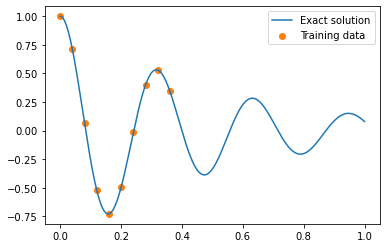

In [5]:
plt.figure()
plt.plot(x_all_data, y_all_data, label="Exact solution")
plt.scatter(x_train_data, y_train_data, color="tab:orange", label="Training data")
plt.legend()
plt.show()

In [6]:
from deepxde.data.data import Data

class DataLoader(Data):
    """Dataset with each data point as a tuple.
    Each data tuple is split into two parts: input tuple (x) and output tuple (y).
    """
    def __init__(self, train_x, train_y, test_x, test_y):
        self.train_x = train_x
        self.train_y = train_y
        self.test_x = test_x
        self.test_y = test_y

    def losses(self, targets, outputs, loss, model):
        return [loss(targets, outputs)]

    def train_next_batch(self, batch_size=None):
        return self.train_x, self.train_y

    def test(self):
        return self.test_x, self.test_y
    
    

    def get_batch_train_data(self, batch_size=None, shuffle=True):
        if batch_size == None:
            batch_size = len(self.train_x)
        return self.get_batches(self.train_x, self.train_y, batch_size, shuffle)


    def get_batch_test_data(self, batch_size=None, shuffle=False):
        if batch_size == None:
            batch_size = len(self.test_x)
        return self.get_batches(self.test_x, self.test_y, batch_size, shuffle)
        
        
    def get_batches(self, inputs, targets, batch_size, shuffle=True): 
        #inputs相当于X，targets相当于Y
        length = len(inputs)
        index = np.array(range(length))
        if shuffle: #shuffle 随机打乱
            np.random.shuffle(index)

        start_idx = 0
        while (start_idx < length):
            end_idx = min(length, start_idx + batch_size)
            excerpt = index[start_idx:end_idx]
            yield inputs[excerpt], targets[excerpt];
            start_idx += batch_size

In [7]:
data = DataLoader(x_train_data, y_train_data, x_all_data, y_all_data)

# data = dde.data.data.Tuple(x_train_data, y_train_data, x_all_data, y_all_data)

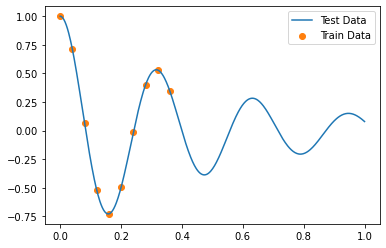

In [8]:
plt.figure()
plt.plot(*data.test(), label="Test Data")
# plt.scatter(*data.test(), label="Test Data")
plt.scatter(*data.train_next_batch(), color="tab:orange", label="Train Data")
plt.legend()
plt.show()

关于获取 batch_size data，deepxde是直接处理数据,不能处理数据生成器。

```python
for batch_x,batch_y in data.get_batch_train_data(batch_size=None):
    print(batch_x.shape, batch_y.shape)

for batch_x,batch_y in data.get_batch_test_data(batch_size=None):
    print(batch_x.shape, batch_y.shape)
```

In [9]:
layer_size = [1] + [32] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
# initializer = "He uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)

In [10]:
model.compile("adam", lr=1e-4, metrics=["l2 relative error"])
losshistory, train_state = model.train(epochs=20000)

Compiling model...
Building feed-forward neural network...
'build' took 0.061978 s



G:\Anaconda3\envs\py3.8\lib\site-packages\keras\legacy_tf_layers\core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
G:\Anaconda3\envs\py3.8\lib\site-packages\keras\engine\base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 2.308237 s

Initializing variables...
Training model...

Step      Train loss    Test loss     Test metric   
0         [3.11e-01]    [1.29e-01]    [1.00e+00]    
1000      [1.03e-01]    [1.71e+00]    [3.64e+00]    
2000      [1.04e-02]    [1.72e-01]    [1.15e+00]    
3000      [1.15e-03]    [7.64e-01]    [2.44e+00]    
4000      [5.48e-04]    [9.42e-01]    [2.71e+00]    
5000      [1.05e-04]    [8.33e-01]    [2.54e+00]    
6000      [3.37e-05]    [7.12e-01]    [2.35e+00]    
7000      [1.64e-05]    [7.10e-01]    [2.35e+00]    
8000      [6.10e-06]    [7.41e-01]    [2.40e+00]    
9000      [1.34e-06]    [7.71e-01]    [2.45e+00]    
10000     [4.91e-07]    [7.89e-01]    [2.48e+00]    
11000     [1.74e-08]    [7.97e-01]    [2.49e+00]    
12000     [4.22e-09]    [8.01e-01]    [2.49e+00]    
13000     [1.68e-09]    [8.03e-01]    [2.50e+00]    
14000     [6.96e-10]    [8.05e-01]    [2.50e+00]    
15000     [9.99e-08]    [8.06e-01]    [2.50e+00]    
16000     [1.18e-07]    [8.

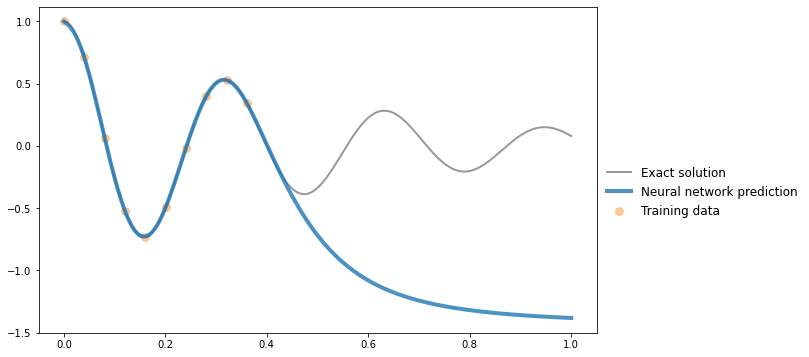

In [12]:
train_data_x,train_data_y = data.train_next_batch()
test_data_x,test_data_y = data.test()
pred_data = model.predict(test_data_x)

plot_result(test_data_x,test_data_y,train_data_x,train_data_y,pred_data)

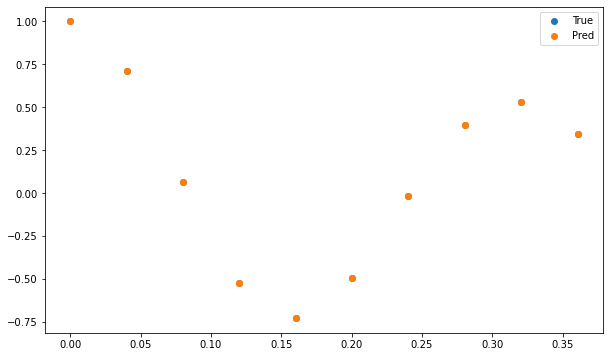

In [13]:
t_list = data.train_next_batch()[0].flatten()
t_list = sorted(t_list)

true_data = [func(t) for t in t_list]
pred_data = model.predict(np.array(t_list).reshape(-1,1))

plt.figure(figsize=(10, 6))
# plt.plot(t_list, true_data, "-k", label="True")
# plt.plot(t_list, pred_data[:,0], "-r", label="Pred")

plt.scatter(t_list, true_data, label="True")
plt.scatter(t_list, pred_data[:,0], label="Pred")

plt.legend()
plt.show()

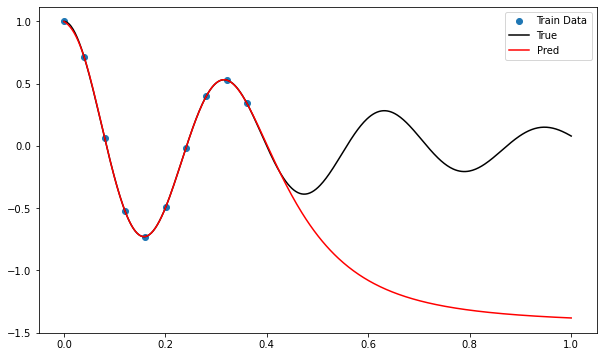

In [14]:
train_data_x,train_data_y = data.train_next_batch()

t_list = data.test()[0].flatten()
t_list = sorted(t_list)

true_data = [func(t) for t in t_list]
pred_data = model.predict(np.array(t_list).reshape(-1,1))

plt.figure(figsize=(10, 6))
plt.scatter(train_data_x, train_data_y, label="Train Data")
plt.plot(t_list, true_data, "-k", label="True")
plt.plot(t_list, pred_data[:,0], "-r", label="Pred")

# plt.scatter(t_list, pred_data[:,0], label="Pred")

plt.legend()
plt.show()

## PINN

> 最后，我们将基础微分方程（“物理损失”）添加到损失函数中。

物理损失旨在确保模型学习的解与微分方程一致。 这是通过在从域中采样的一组位置上惩罚微分方程的残差来完成的。

在这里，我们评估在问题域 $([0,1])$ 上均匀分布的 30 个点的物理损失。 我们可以使用自动微分计算网络解相对于其输入变量在这些点处的导数，然后可以使用这些量轻松计算微分方程的残差。

使用DeepXDE求解微分方程的步骤：

    Step 1 使用几何模块指定计算域。
    Step 2 按照DeepXDE后端的深度学习框架，使用TensorFlow、Pytorch等的语法指定微分方程。
    Step 3 指定边界和初始条件。
    Step 4 将几何、偏微分方程和边界/初始条件一起组合到 data.PDE 或 data.TimePDE 中，分别用于时间无关问题或时间相关问题。要指定训练数据，可以设置特定的点位置，或者只设置点的数量，然后 DeepXDE将在网格上或随机采样所需数量的点。
    Step 5 使用maps模块构建神经网络。
    Step 6 通过结合第 4 步中的 PDE 问题和第 5 步中的神经网络来定义模型。
    Step 7 调用Model.compile设置优化超参数，例如优化器、学习率和损失权重。
    Step 8 调用Model.train从随机初始化或使用参数模型恢复路径的预训练模型训练网络。使用回调来监控和修改训练行为非常灵活。
    Step 9 调用Model.predict预测不同位置的PDE解。



In [17]:
def pde(t, x):
    dx_t = dde.grad.jacobian(x, t)
    dx_tt = dde.grad.hessian(x, t)
    # return m*dx_tt + mu*dx_t + k*x
    return dx_tt + mu/m*dx_t + k/m*x

def boundary(x, on_boundary):
    return on_boundary and np.isclose(x[0], 0)

def func(t):
    # omega = np.sqrt(omega_0**2-delta**2)
    # phi = np.arctan(-delta/omega)
    # A = 1/(2*np.cos(phi))
    return np.exp(-delta*t)*2*A*np.cos(omega*t+phi)


geom = dde.geometry.TimeDomain(0., 1.)
# ic_1 = dde.icbc.initial_conditions.IC(geom, lambda x: 1., boundary, component=0) # 初值条件 x(0) = 1.
ic_2 = dde.icbc.boundary_conditions.NeumannBC(geom, lambda x: 0.*x, boundary, component=0) # 导数条件 dx(0)/dt = 0

# ic_2 = dde.icbc.OperatorBC(
#     geom,
#     lambda x, y, _: dde.grad.jacobian(y, x),
#     boundary,
# ) # 导数条件 dx(0)/dt = 0


x_train_data = x_all_data[0:200:20]  # 数组切片
y_train_data = y_all_data[0:200:20]
observe_y = dde.icbc.boundary_conditions.PointSetBC(points=x_train_data, values=y_train_data, component=0)


data = dde.data.PDE(geom, pde, [observe_y, ic_2], 30, 1, solution=func, num_test=500)
layer_size = [1] + [32] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)

In [18]:
model.compile("adam", lr=1e-4, metrics=["l2 relative error"],loss_weights = [1, 1e4, 1])
losshistory, train_state = model.train(epochs=20000)

Compiling model...
Building feed-forward neural network...
'build' took 0.056479 s

'compile' took 0.419350 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric   
0         [2.77e+02, 3.14e+03, 5.45e-03]    [2.87e+02, 3.14e+03, 5.45e-03]    [1.01e+00]    
1000      [2.12e+01, 3.06e+03, 2.81e-03]    [1.89e+01, 3.06e+03, 2.81e-03]    [9.97e-01]    
2000      [3.77e+01, 3.03e+03, 4.54e-02]    [3.13e+01, 3.03e+03, 4.54e-02]    [9.92e-01]    
3000      [1.73e+02, 2.18e+03, 1.90e+00]    [1.30e+02, 2.18e+03, 1.90e+00]    [8.87e-01]    
4000      [4.74e+02, 8.44e+02, 8.36e+00]    [3.29e+02, 8.44e+02, 8.36e+00]    [6.41e-01]    
5000      [2.78e+02, 6.93e+01, 1.72e-04]    [3.09e+02, 6.93e+01, 1.72e-04]    [3.86e-01]    
6000      [1.91e+02, 2.48e+01, 4.44e-04]    [2.09e+02, 2.48e+01, 4.44e-04]    [3.12e-01]    
7000      [1.01e+02, 6.70e+00, 2.61e-02]    [1.17e+02, 6.70e+00, 2.61e-02]    [2.03e-01]    
8000   

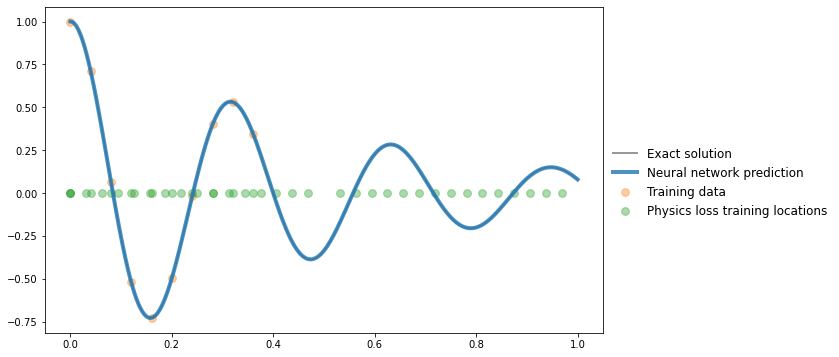

In [23]:
pred_data = model.predict(x_all_data)
residual_points = sorted(data.train_next_batch()[0])# residual_points, sample_points
plot_result(x_all_data,y_all_data,x_train_data,y_train_data,pred_data, residual_points)

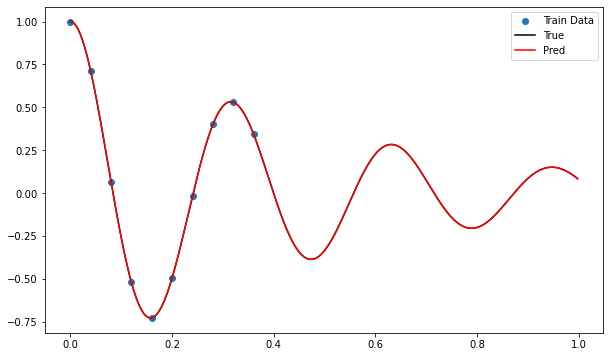

In [22]:
t_list = data.test()[0].flatten()
t_list = sorted(t_list)

true_data = [func(t) for t in t_list]
pred_data = model.predict(np.array(t_list).reshape(-1,1))

plt.figure(figsize=(10, 6))
plt.scatter(x_train_data, y_train_data, label="Train Data") # observe_y.points,observe_y.values
plt.plot(t_list, true_data, "-k", label="True")
plt.plot(t_list, pred_data[:,0], "-r", label="Pred")
# plt.scatter(t_list, pred_data[:,0], label="Pred")

plt.legend()
plt.show()

PointSetBC可以设置一般的值(包括初值条件IC和一些中间值)， OperatorBC可以设置一般的边界条件(包括DirichletBC，NeumannBC，RobinBC，PeriodicBC)

In [28]:

def slove_pde(x_all_data, y_all_data, x_train_data, y_train_data, pde, func, sample_number:int = 30):
    geom = dde.geometry.TimeDomain(0., 1.)
    # ic_1 = dde.icbc.initial_conditions.IC(geom, lambda x: 1., boundary, component=0) # 初值条件 x(0) = 1.
    observe_y = dde.icbc.boundary_conditions.PointSetBC(points=x_train_data, values=y_train_data, component=0)
    ic_2 = dde.icbc.boundary_conditions.NeumannBC(geom, lambda x: 0.*x, boundary, component=0) # 导数条件 dx(0)/dt = 0
    # ic_2 = dde.icbc.OperatorBC(
    #     geom,
    #     lambda x, y, _: dde.grad.jacobian(y, x),
    #     boundary,
    # ) # 导数条件 dx(0)/dt = 0

    data = dde.data.PDE(geom, pde, [observe_y, ic_2], sample_number, 1, solution=func, num_test=500)
    layer_size = [1] + [32] * 3 + [1]
    activation = "tanh"
    initializer = "Glorot uniform"
    net = dde.nn.FNN(layer_size, activation, initializer)
    model = dde.Model(data, net)
    model.compile("adam", lr=1e-4, metrics=["l2 relative error"],loss_weights=[1, 1e4, 1])
    losshistory, train_state = model.train(epochs=20000)

    pred_data = model.predict(x_all_data)
    residual_points = sorted(data.train_next_batch()[0])# residual_points, sample_points
    plot_result(x_all_data,y_all_data,x_train_data,y_train_data,pred_data, residual_points)
    


## 增添项

### 给初值

Compiling model...
Building feed-forward neural network...
'build' took 0.052158 s



G:\Anaconda3\envs\py3.8\lib\site-packages\keras\legacy_tf_layers\core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
G:\Anaconda3\envs\py3.8\lib\site-packages\keras\engine\base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 0.467434 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric   
0         [5.93e+01, 3.10e+03, 2.20e-03]    [6.12e+01, 3.10e+03, 2.20e-03]    [1.00e+00]    
1000      [3.43e+01, 3.04e+03, 3.20e-02]    [2.87e+01, 3.04e+03, 3.20e-02]    [9.93e-01]    
2000      [2.07e+02, 2.06e+03, 2.56e+00]    [1.47e+02, 2.06e+03, 2.56e+00]    [8.69e-01]    
3000      [3.59e+02, 4.51e+02, 1.04e+00]    [3.29e+02, 4.51e+02, 1.04e+00]    [5.55e-01]    
4000      [2.27e+02, 3.35e+01, 3.85e-02]    [3.04e+02, 3.35e+01, 3.85e-02]    [3.43e-01]    
5000      [1.26e+02, 1.26e+01, 6.87e-02]    [1.81e+02, 1.26e+01, 6.87e-02]    [2.51e-01]    
6000      [8.38e+01, 3.05e+00, 1.20e-01]    [1.59e+02, 3.05e+00, 1.20e-01]    [1.77e-01]    
7000      [6.61e+01, 2.02e+00, 1.38e-01]    [1.41e+02, 2.02e+00, 1.38e-01]    [1.52e-01]    
8000      [4.87e+01, 1.34e+00, 1.25e-01]    [1.22e+02, 1.34e+00, 1.25e-01]    [1.26e-01]   

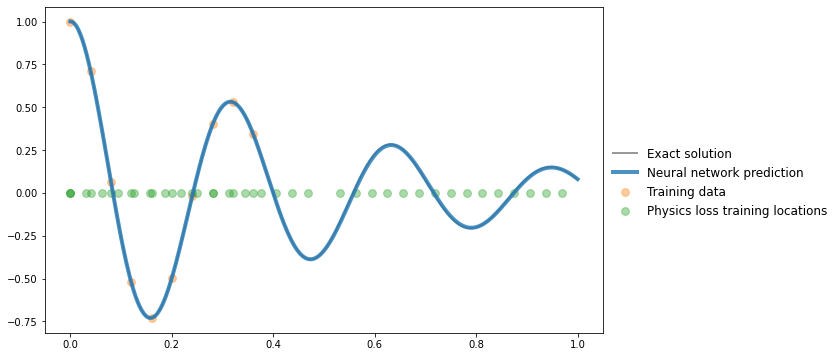

In [26]:
x_train_data = x_all_data[0:200:20]  # 给部分值
y_train_data = y_all_data[0:200:20]

slove_pde(x_all_data, y_all_data, x_train_data, y_train_data, pde, func, sample_number=30)

Compiling model...
Building feed-forward neural network...
'build' took 0.053149 s



G:\Anaconda3\envs\py3.8\lib\site-packages\keras\legacy_tf_layers\core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
G:\Anaconda3\envs\py3.8\lib\site-packages\keras\engine\base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 0.620958 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric   
0         [5.24e+03, 1.00e+04, 1.07e-01]    [5.45e+03, 1.00e+04, 1.07e-01]    [1.12e+00]    
1000      [1.58e+03, 6.38e+03, 1.06e-01]    [1.45e+03, 6.38e+03, 1.06e-01]    [1.01e+00]    
2000      [2.21e+03, 3.60e+03, 5.70e+00]    [1.75e+03, 3.60e+03, 5.70e+00]    [9.59e-01]    
3000      [1.61e+03, 1.01e+03, 2.20e+01]    [1.21e+03, 1.01e+03, 2.20e+01]    [7.71e-01]    
4000      [1.29e+03, 3.98e+02, 1.94e+01]    [1.12e+03, 3.98e+02, 1.94e+01]    [6.94e-01]    
5000      [1.14e+03, 3.37e+02, 1.01e+01]    [1.02e+03, 3.37e+02, 1.01e+01]    [6.78e-01]    
6000      [7.67e+02, 1.32e+02, 1.27e+00]    [7.59e+02, 1.32e+02, 1.27e+00]    [5.94e-01]    
7000      [2.67e+02, 9.24e+00, 1.24e-02]    [4.84e+02, 9.24e+00, 1.24e-02]    [3.76e-01]    
8000      [1.44e+02, 2.97e+00, 4.46e-01]    [3.94e+02, 2.97e+00, 4.46e-01]    [2.79e-01]   

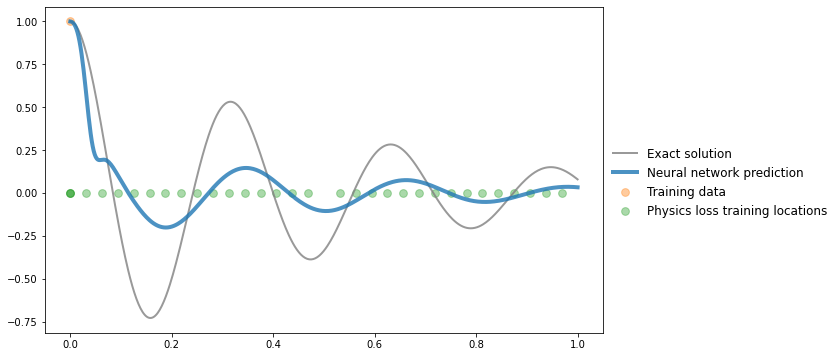

In [35]:
x_train_data = x_all_data[0:200:200] # 只给初值
y_train_data = y_all_data[0:200:200]

slove_pde(x_all_data, y_all_data, x_train_data, y_train_data, pde, func, sample_number=30)

Compiling model...
Building feed-forward neural network...
'build' took 0.052987 s



G:\Anaconda3\envs\py3.8\lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+12=12. 
  warnings.warn("The balance properties of Sobol' points require "
G:\Anaconda3\envs\py3.8\lib\site-packages\keras\legacy_tf_layers\core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
G:\Anaconda3\envs\py3.8\lib\site-packages\keras\engine\base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 0.585361 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric   
0         [3.98e+03, 1.00e+04, 8.82e-02]    [4.16e+03, 1.00e+04, 8.82e-02]    [1.09e+00]    
1000      [1.62e+03, 5.30e+03, 9.21e-01]    [1.20e+03, 5.30e+03, 9.21e-01]    [9.85e-01]    
2000      [2.27e+03, 3.52e+03, 7.11e+00]    [1.34e+03, 3.52e+03, 7.11e+00]    [9.36e-01]    
3000      [5.78e+01, 1.93e+00, 6.14e+01]    [4.19e+03, 1.93e+00, 6.14e+01]    [7.86e-01]    
4000      [3.39e+01, 4.14e-01, 1.38e+01]    [5.82e+03, 4.14e-01, 1.38e+01]    [7.99e-01]    
5000      [6.24e+00, 2.22e-02, 1.12e+00]    [9.06e+03, 2.22e-02, 1.12e+00]    [8.23e-01]    
6000      [2.83e+00, 1.23e-05, 3.77e-03]    [1.03e+04, 1.24e-05, 3.77e-03]    [8.28e-01]    
7000      [1.21e+00, 2.95e-05, 1.98e-03]    [1.05e+04, 2.97e-05, 1.98e-03]    [8.28e-01]    
8000      [4.29e-01, 1.34e-06, 7.74e-04]    [1.07e+04, 1.34e-06, 7.74e-04]    [8.27e-01]   

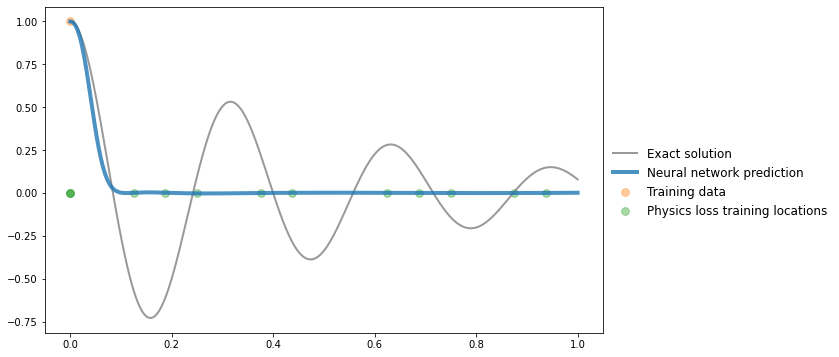

In [33]:
x_train_data = x_all_data[0:200:200] # 只给初值
y_train_data = y_all_data[0:200:200]

slove_pde(x_all_data, y_all_data, x_train_data, y_train_data, pde, func, sample_number=10)

Compiling model...
Building feed-forward neural network...
'build' took 0.052202 s



G:\Anaconda3\envs\py3.8\lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+12=12. 
  warnings.warn("The balance properties of Sobol' points require "
G:\Anaconda3\envs\py3.8\lib\site-packages\keras\legacy_tf_layers\core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
G:\Anaconda3\envs\py3.8\lib\site-packages\keras\engine\base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 0.648389 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric   
0         [1.21e+02, 3.10e+03, 2.65e-03]    [1.26e+02, 3.10e+03, 2.65e-03]    [1.00e+00]    
1000      [2.72e+01, 3.05e+03, 1.28e-02]    [2.05e+01, 3.05e+03, 1.28e-02]    [9.95e-01]    
2000      [8.66e+01, 2.92e+03, 7.01e-01]    [4.44e+01, 2.92e+03, 7.01e-01]    [9.81e-01]    
3000      [1.23e+02, 1.29e+03, 2.30e+01]    [4.00e+03, 1.29e+03, 2.30e+01]    [7.66e-01]    
4000      [1.98e+02, 2.30e+02, 2.57e-01]    [2.27e+03, 2.30e+02, 2.57e-01]    [4.67e-01]    
5000      [2.52e+01, 1.44e+01, 4.92e-01]    [2.60e+03, 1.44e+01, 4.92e-01]    [3.39e-01]    
6000      [4.57e+00, 5.44e+00, 3.28e-01]    [3.33e+03, 5.44e+00, 3.28e-01]    [3.37e-01]    
7000      [4.14e-01, 2.34e+00, 2.23e-01]    [4.20e+03, 2.34e+00, 2.23e-01]    [3.51e-01]    
8000      [1.60e-01, 1.23e+00, 1.54e-01]    [4.09e+03, 1.23e+00, 1.54e-01]    [3.59e-01]   

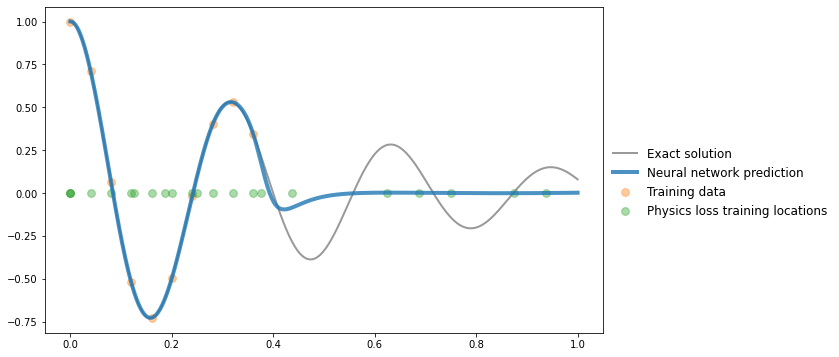

In [34]:
x_train_data = x_all_data[0:200:20]  # 给部分值
y_train_data = y_all_data[0:200:20]

slove_pde(x_all_data, y_all_data, x_train_data, y_train_data, pde, func, sample_number=10)

Compiling model...
Building feed-forward neural network...
'build' took 0.055659 s



G:\Anaconda3\envs\py3.8\lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+52=52. 
  warnings.warn("The balance properties of Sobol' points require "
G:\Anaconda3\envs\py3.8\lib\site-packages\keras\legacy_tf_layers\core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
G:\Anaconda3\envs\py3.8\lib\site-packages\keras\engine\base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 0.649078 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric   
0         [3.04e+03, 1.00e+04, 5.89e-02]    [3.11e+03, 1.00e+04, 5.89e-02]    [1.07e+00]    
1000      [1.51e+03, 5.72e+03, 3.49e-01]    [1.41e+03, 5.72e+03, 3.49e-01]    [1.00e+00]    
2000      [2.17e+03, 2.20e+03, 2.03e+01]    [1.88e+03, 2.20e+03, 2.03e+01]    [9.01e-01]    
3000      [1.37e+03, 4.30e+02, 2.34e+01]    [1.12e+03, 4.30e+02, 2.34e+01]    [6.92e-01]    
4000      [1.19e+03, 2.68e+02, 2.80e+01]    [9.93e+02, 2.68e+02, 2.80e+01]    [6.37e-01]    
5000      [4.91e+02, 4.73e+01, 1.59e+00]    [4.81e+02, 4.73e+01, 1.59e+00]    [4.84e-01]    
6000      [3.09e+02, 1.11e+01, 2.18e-01]    [3.33e+02, 1.11e+01, 2.18e-01]    [3.97e-01]    
7000      [2.56e+02, 7.71e+00, 4.65e-01]    [2.83e+02, 7.71e+00, 4.65e-01]    [3.65e-01]    
8000      [1.77e+02, 4.06e+00, 9.49e-01]    [2.01e+02, 4.06e+00, 9.49e-01]    [3.11e-01]   

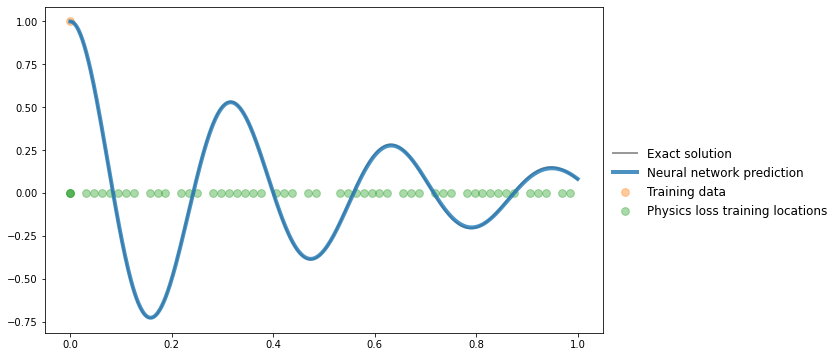

In [36]:
x_train_data = x_all_data[0:200:200]  # 只给初值
y_train_data = y_all_data[0:200:200]

slove_pde(x_all_data, y_all_data, x_train_data, y_train_data, pde, func, sample_number=50)

Compiling model...
Building feed-forward neural network...
'build' took 0.054839 s



G:\Anaconda3\envs\py3.8\lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+102=102. 
  warnings.warn("The balance properties of Sobol' points require "
G:\Anaconda3\envs\py3.8\lib\site-packages\keras\legacy_tf_layers\core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
G:\Anaconda3\envs\py3.8\lib\site-packages\keras\engine\base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 0.803644 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric   
0         [6.78e+03, 1.00e+04, 1.32e-01]    [6.81e+03, 1.00e+04, 1.32e-01]    [1.15e+00]    
1000      [1.56e+03, 6.08e+03, 1.64e-01]    [1.52e+03, 6.08e+03, 1.64e-01]    [1.01e+00]    
2000      [2.15e+03, 2.71e+03, 1.16e+01]    [1.94e+03, 2.71e+03, 1.16e+01]    [9.35e-01]    
3000      [1.33e+03, 5.62e+02, 1.87e+01]    [1.28e+03, 5.62e+02, 1.87e+01]    [7.41e-01]    
4000      [1.20e+03, 3.08e+02, 1.40e+01]    [1.20e+03, 3.08e+02, 1.40e+01]    [6.89e-01]    
5000      [9.77e+02, 2.40e+02, 6.70e+00]    [9.73e+02, 2.40e+02, 6.70e+00]    [6.57e-01]    
6000      [6.31e+02, 1.10e+02, 6.84e+00]    [6.14e+02, 1.10e+02, 6.84e+00]    [5.54e-01]    
7000      [3.67e+02, 2.53e+01, 1.00e+01]    [3.52e+02, 2.53e+01, 1.00e+01]    [4.24e-01]    
8000      [2.96e+02, 1.30e+01, 2.27e+00]    [2.88e+02, 1.30e+01, 2.27e+00]    [3.79e-01]   

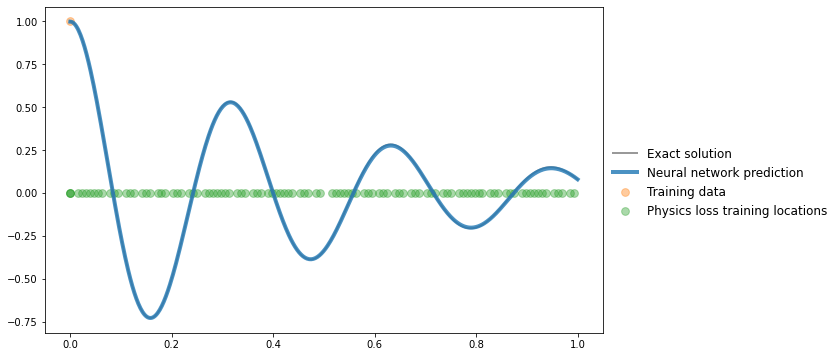

In [43]:
x_train_data = x_all_data[0:200:200]  # 只给初值
y_train_data = y_all_data[0:200:200]

slove_pde(x_all_data, y_all_data, x_train_data, y_train_data, pde, func, sample_number=100)

### 中间值

Compiling model...
Building feed-forward neural network...
'build' took 0.055831 s



G:\Anaconda3\envs\py3.8\lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+102=102. 
  warnings.warn("The balance properties of Sobol' points require "
G:\Anaconda3\envs\py3.8\lib\site-packages\keras\legacy_tf_layers\core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
G:\Anaconda3\envs\py3.8\lib\site-packages\keras\engine\base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 1.258519 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric   
0         [1.34e+04, 4.16e+02, 3.28e-01]    [1.34e+04, 4.16e+02, 3.28e-01]    [1.29e+00]    
1000      [9.55e+01, 4.92e+02, 1.83e-03]    [9.42e+01, 4.92e+02, 1.83e-03]    [1.01e+00]    
2000      [9.12e+01, 4.78e+02, 6.05e-03]    [8.92e+01, 4.78e+02, 6.05e-03]    [1.01e+00]    
3000      [1.06e+02, 4.35e+02, 4.08e-02]    [1.01e+02, 4.35e+02, 4.08e-02]    [1.01e+00]    
4000      [1.13e+02, 4.26e+02, 4.95e-02]    [1.08e+02, 4.26e+02, 4.95e-02]    [1.01e+00]    
5000      [1.14e+02, 4.23e+02, 4.33e-02]    [1.09e+02, 4.23e+02, 4.33e-02]    [1.01e+00]    
6000      [1.16e+02, 4.09e+02, 1.44e-02]    [1.11e+02, 4.09e+02, 1.44e-02]    [1.01e+00]    
7000      [9.69e+01, 2.44e+02, 1.98e+00]    [9.75e+01, 2.44e+02, 1.98e+00]    [9.82e-01]    
8000      [7.90e+01, 3.10e+01, 1.95e+01]    [7.81e+01, 3.10e+01, 1.95e+01]    [9.67e-01]   

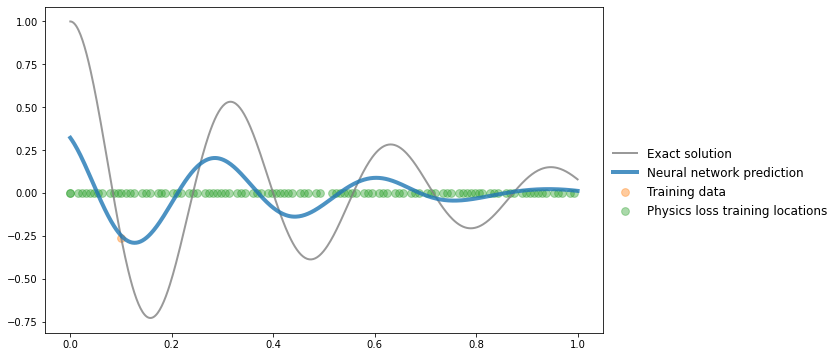

In [44]:
x_train_data = x_all_data[50:200:200]  # 中间某一个值
y_train_data = y_all_data[50:200:200]

slove_pde(x_all_data, y_all_data, x_train_data, y_train_data, pde, func, sample_number=100)

Compiling model...
Building feed-forward neural network...
'build' took 0.056133 s



G:\Anaconda3\envs\py3.8\lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+102=102. 
  warnings.warn("The balance properties of Sobol' points require "
G:\Anaconda3\envs\py3.8\lib\site-packages\keras\legacy_tf_layers\core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
G:\Anaconda3\envs\py3.8\lib\site-packages\keras\engine\base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 0.891846 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric   
0         [3.69e+04, 2.81e+03, 8.64e-01]    [3.71e+04, 2.81e+03, 8.64e-01]    [1.66e+00]    
1000      [2.37e+01, 2.07e+03, 2.37e-05]    [2.36e+01, 2.07e+03, 2.37e-05]    [1.00e+00]    
2000      [2.19e+01, 2.06e+03, 6.68e-04]    [2.15e+01, 2.06e+03, 6.68e-04]    [1.00e+00]    
3000      [2.21e+01, 2.04e+03, 3.50e-03]    [2.15e+01, 2.04e+03, 3.50e-03]    [1.00e+00]    
4000      [4.13e+01, 2.00e+03, 2.53e-02]    [3.96e+01, 2.00e+03, 2.53e-02]    [1.01e+00]    
5000      [5.65e+01, 1.98e+03, 4.22e-02]    [5.42e+01, 1.98e+03, 4.22e-02]    [1.01e+00]    
6000      [5.71e+01, 1.98e+03, 4.53e-02]    [5.46e+01, 1.98e+03, 4.53e-02]    [1.01e+00]    
7000      [5.94e+01, 1.97e+03, 4.85e-02]    [5.65e+01, 1.97e+03, 4.85e-02]    [1.01e+00]    
8000      [7.94e+01, 1.88e+03, 8.17e-03]    [7.68e+01, 1.88e+03, 8.17e-03]    [1.00e+00]   

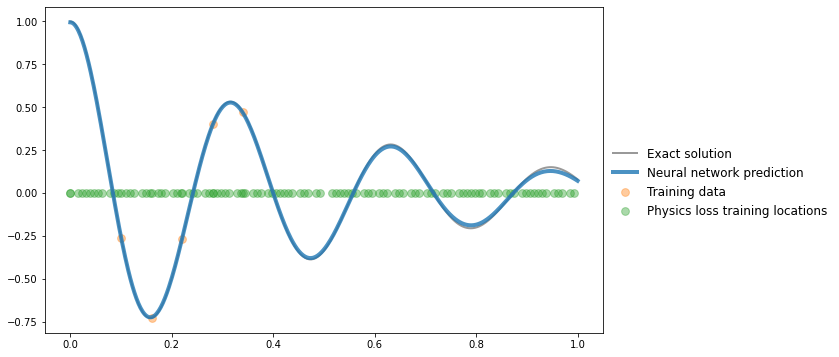

In [45]:
x_train_data = x_all_data[50:200:30]  # 中间某些值
y_train_data = y_all_data[50:200:30]

slove_pde(x_all_data, y_all_data, x_train_data, y_train_data, pde, func, sample_number=100)

Compiling model...
Building feed-forward neural network...
'build' took 0.056869 s



G:\Anaconda3\envs\py3.8\lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+102=102. 
  warnings.warn("The balance properties of Sobol' points require "
G:\Anaconda3\envs\py3.8\lib\site-packages\keras\legacy_tf_layers\core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
G:\Anaconda3\envs\py3.8\lib\site-packages\keras\engine\base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 0.902335 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric   
0         [4.20e+03, 1.89e+03, 8.67e-02]    [4.21e+03, 1.89e+03, 8.67e-02]    [1.09e+00]    
1000      [1.95e+01, 1.85e+03, 2.07e-03]    [1.90e+01, 1.85e+03, 2.07e-03]    [1.00e+00]    
2000      [2.04e+01, 1.85e+03, 3.72e-03]    [1.97e+01, 1.85e+03, 3.72e-03]    [1.00e+00]    
3000      [2.48e+01, 1.83e+03, 9.15e-03]    [2.39e+01, 1.83e+03, 9.15e-03]    [1.01e+00]    
4000      [4.03e+01, 1.81e+03, 2.59e-02]    [3.87e+01, 1.81e+03, 2.59e-02]    [1.01e+00]    
5000      [4.51e+01, 1.81e+03, 3.28e-02]    [4.32e+01, 1.81e+03, 3.28e-02]    [1.01e+00]    
6000      [4.60e+01, 1.80e+03, 3.70e-02]    [4.40e+01, 1.80e+03, 3.70e-02]    [1.01e+00]    
7000      [5.00e+01, 1.79e+03, 3.68e-02]    [4.76e+01, 1.79e+03, 3.68e-02]    [1.01e+00]    
8000      [2.93e+02, 9.15e+02, 4.27e+00]    [2.97e+02, 9.15e+02, 4.27e+00]    [8.46e-01]   

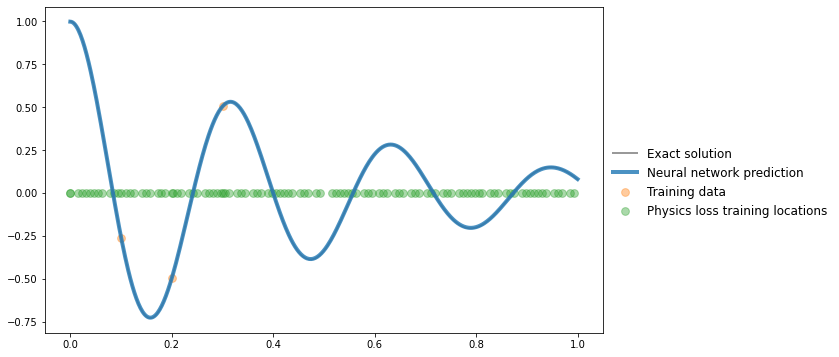

In [47]:
x_train_data = x_all_data[50:200:50]  # 中间某些值
y_train_data = y_all_data[50:200:50]

slove_pde(x_all_data, y_all_data, x_train_data, y_train_data, pde, func, sample_number=100)

Compiling model...
Building feed-forward neural network...
'build' took 0.056079 s



G:\Anaconda3\envs\py3.8\lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+102=102. 
  warnings.warn("The balance properties of Sobol' points require "
G:\Anaconda3\envs\py3.8\lib\site-packages\keras\legacy_tf_layers\core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
G:\Anaconda3\envs\py3.8\lib\site-packages\keras\engine\base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 0.961250 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric   
0         [2.80e+03, 1.96e+03, 6.08e-02]    [2.81e+03, 1.96e+03, 6.08e-02]    [1.07e+00]    
1000      [1.25e+01, 1.58e+03, 2.54e-03]    [1.27e+01, 1.58e+03, 2.54e-03]    [1.00e+00]    
2000      [4.96e+01, 1.51e+03, 3.96e-02]    [4.96e+01, 1.51e+03, 3.96e-02]    [1.01e+00]    
3000      [7.24e+01, 1.46e+03, 1.52e-01]    [7.09e+01, 1.46e+03, 1.52e-01]    [1.01e+00]    
4000      [1.15e+02, 1.36e+03, 4.96e-01]    [1.09e+02, 1.36e+03, 4.96e-01]    [1.02e+00]    
5000      [2.47e+02, 6.50e+02, 6.49e+00]    [2.46e+02, 6.50e+02, 6.49e+00]    [8.96e-01]    
6000      [2.87e+02, 3.01e+02, 2.08e+01]    [2.91e+02, 3.01e+02, 2.08e+01]    [8.26e-01]    
7000      [2.30e+02, 1.97e+02, 2.82e+01]    [2.27e+02, 1.97e+02, 2.82e+01]    [7.65e-01]    
8000      [1.51e+02, 1.10e+02, 2.09e+01]    [1.39e+02, 1.10e+02, 2.09e+01]    [6.00e-01]   

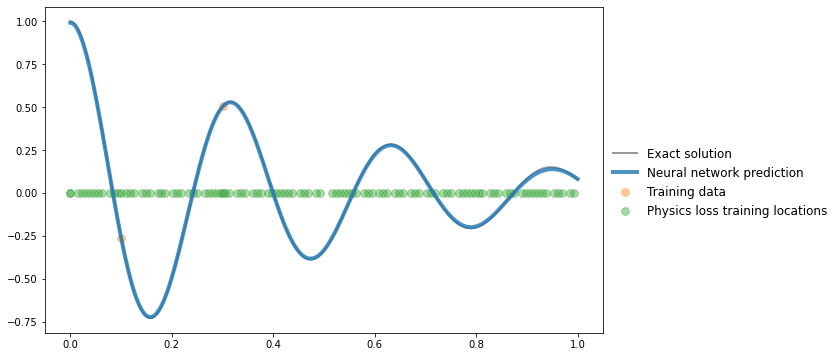

In [50]:
x_train_data = x_all_data[50:200:100]  # 给中间的某些值，步长更大，更稀疏
y_train_data = y_all_data[50:200:100]

slove_pde(x_all_data, y_all_data, x_train_data, y_train_data, pde, func, sample_number=100)

Compiling model...
Building feed-forward neural network...
'build' took 0.054830 s



G:\Anaconda3\envs\py3.8\lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+102=102. 
  warnings.warn("The balance properties of Sobol' points require "
G:\Anaconda3\envs\py3.8\lib\site-packages\keras\legacy_tf_layers\core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
G:\Anaconda3\envs\py3.8\lib\site-packages\keras\engine\base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 1.685346 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric   
0         [9.84e+03, 1.52e+03, 2.02e-01]    [9.88e+03, 1.52e+03, 2.02e-01]    [1.22e+00]    
1000      [1.41e-01, 1.10e+03, 1.94e-05]    [1.37e-01, 1.10e+03, 1.94e-05]    [1.00e+00]    
2000      [1.50e-01, 1.10e+03, 3.20e-05]    [1.46e-01, 1.10e+03, 3.20e-05]    [1.00e+00]    
3000      [1.77e-01, 1.10e+03, 6.07e-05]    [1.71e-01, 1.10e+03, 6.07e-05]    [1.00e+00]    
4000      [2.48e-01, 1.10e+03, 1.24e-04]    [2.39e-01, 1.10e+03, 1.24e-04]    [1.00e+00]    
5000      [4.16e-01, 1.10e+03, 2.64e-04]    [4.03e-01, 1.10e+03, 2.64e-04]    [1.00e+00]    
6000      [7.60e-01, 1.10e+03, 5.49e-04]    [7.40e-01, 1.10e+03, 5.49e-04]    [1.00e+00]    
7000      [1.26e+00, 1.10e+03, 1.04e-03]    [1.23e+00, 1.10e+03, 1.04e-03]    [1.00e+00]    
8000      [1.83e+00, 1.10e+03, 2.00e-03]    [1.78e+00, 1.10e+03, 2.00e-03]    [1.00e+00]   

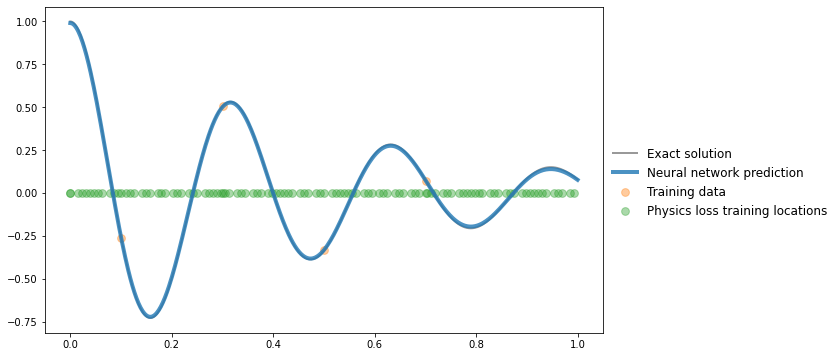

In [51]:
x_train_data = x_all_data[50:400:100]  # 中间某些值
y_train_data = y_all_data[50:400:100]

slove_pde(x_all_data, y_all_data, x_train_data, y_train_data, pde, func, sample_number=100)

Compiling model...
Building feed-forward neural network...
'build' took 0.058017 s



G:\Anaconda3\envs\py3.8\lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+102=102. 
  warnings.warn("The balance properties of Sobol' points require "
G:\Anaconda3\envs\py3.8\lib\site-packages\keras\legacy_tf_layers\core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
G:\Anaconda3\envs\py3.8\lib\site-packages\keras\engine\base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 1.088023 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric   
0         [1.09e+03, 6.34e+02, 2.47e-02]    [1.10e+03, 6.34e+02, 2.47e-02]    [1.03e+00]    
1000      [6.42e+01, 7.59e+02, 1.77e-04]    [6.37e+01, 7.59e+02, 1.77e-04]    [1.00e+00]    
2000      [6.61e+01, 7.57e+02, 2.02e-05]    [6.59e+01, 7.57e+02, 2.02e-05]    [1.00e+00]    
3000      [6.66e+01, 7.56e+02, 7.55e-05]    [6.65e+01, 7.56e+02, 7.55e-05]    [1.00e+00]    
4000      [6.67e+01, 7.56e+02, 7.80e-05]    [6.65e+01, 7.56e+02, 7.80e-05]    [1.00e+00]    
5000      [6.67e+01, 7.56e+02, 7.81e-05]    [6.65e+01, 7.56e+02, 7.81e-05]    [1.00e+00]    
6000      [6.67e+01, 7.56e+02, 7.69e-05]    [6.65e+01, 7.56e+02, 7.69e-05]    [1.00e+00]    
7000      [6.78e+01, 7.55e+02, 7.83e-05]    [6.77e+01, 7.55e+02, 7.83e-05]    [1.00e+00]    
8000      [6.67e+01, 7.56e+02, 6.04e-05]    [6.65e+01, 7.56e+02, 6.04e-05]    [1.00e+00]   

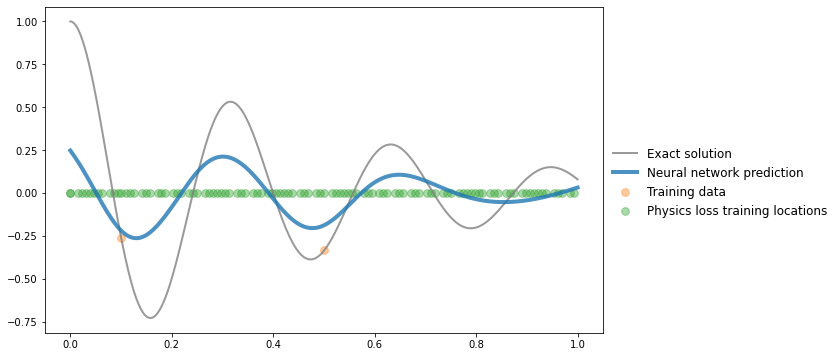

In [53]:
x_train_data = x_all_data[50:400:200]  # 给中间的某些值，步长更大，更稀疏
y_train_data = y_all_data[50:400:200]

slove_pde(x_all_data, y_all_data, x_train_data, y_train_data, pde, func, sample_number=100)

Compiling model...
Building feed-forward neural network...
'build' took 0.061387 s



G:\Anaconda3\envs\py3.8\lib\site-packages\keras\legacy_tf_layers\core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
G:\Anaconda3\envs\py3.8\lib\site-packages\keras\engine\base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 1.232614 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric   
0         [8.33e+03, nan, nan]              [7.93e+03, nan, nan]              [1.17e+00]    

Best model at step 0:
  train loss: inf
  test loss: inf
  test metric: 

'train' took 2.758610 s



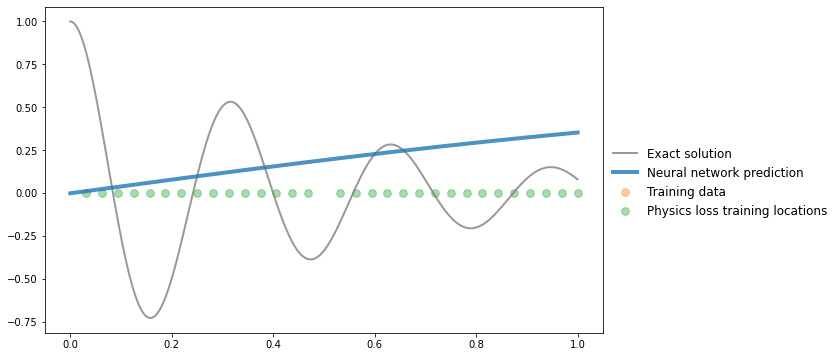

In [68]:
x_train_data = x_all_data[0:0:200]  # 没有数据
y_train_data = y_all_data[0:0:200]

slove_pde(x_all_data, y_all_data, x_train_data, y_train_data, pde, func, sample_number=30)

### 给一些错误的数据

Compiling model...
Building feed-forward neural network...
'build' took 0.058986 s



G:\Anaconda3\envs\py3.8\lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+102=102. 
  warnings.warn("The balance properties of Sobol' points require "
G:\Anaconda3\envs\py3.8\lib\site-packages\keras\legacy_tf_layers\core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
G:\Anaconda3\envs\py3.8\lib\site-packages\keras\engine\base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 1.419934 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric   
0         [2.49e+04, 4.00e+04, 5.09e-01]    [2.50e+04, 4.00e+04, 5.09e-01]    [1.48e+00]    
1000      [6.47e+03, 2.49e+04, 4.62e-01]    [6.33e+03, 2.49e+04, 4.62e-01]    [1.11e+00]    
2000      [7.77e+03, 1.49e+04, 1.43e+01]    [7.23e+03, 1.49e+04, 1.43e+01]    [1.04e+00]    
3000      [5.99e+03, 3.60e+03, 6.80e+01]    [5.58e+03, 3.60e+03, 6.80e+01]    [7.79e-01]    
4000      [5.22e+03, 1.69e+03, 5.40e+01]    [5.20e+03, 1.69e+03, 5.40e+01]    [7.11e-01]    
5000      [4.59e+03, 1.34e+03, 5.58e+01]    [4.54e+03, 1.34e+03, 5.58e+01]    [6.84e-01]    
6000      [2.30e+03, 3.06e+02, 6.53e+01]    [2.22e+03, 3.06e+02, 6.53e+01]    [6.56e-01]    
7000      [1.22e+03, 5.90e+01, 1.24e+01]    [1.22e+03, 5.90e+01, 1.24e+01]    [7.46e-01]    
8000      [8.89e+02, 2.34e+01, 1.15e+00]    [8.84e+02, 2.34e+01, 1.15e+00]    [8.03e-01]   

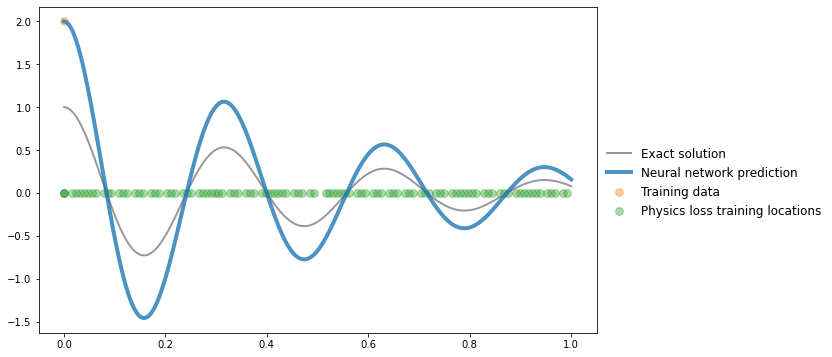

In [77]:
x_train_data = x_all_data[0:200:200]  # 错误的中间数据，带入微分方程有解，但是与原条件的解不匹配
y_train_data = y_all_data[0:200:200]*2

slove_pde(x_all_data, y_all_data, x_train_data, y_train_data, pde, func, sample_number=100)

Compiling model...
Building feed-forward neural network...
'build' took 0.057808 s



G:\Anaconda3\envs\py3.8\lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+102=102. 
  warnings.warn("The balance properties of Sobol' points require "
G:\Anaconda3\envs\py3.8\lib\site-packages\keras\legacy_tf_layers\core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
G:\Anaconda3\envs\py3.8\lib\site-packages\keras\engine\base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 1.476888 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric   
0         [3.90e+03, 2.50e+03, 8.66e-02]    [3.92e+03, 2.50e+03, 8.66e-02]    [1.09e+00]    
1000      [3.93e+02, 1.47e+03, 5.42e-02]    [3.81e+02, 1.47e+03, 5.42e-02]    [9.95e-01]    
2000      [5.63e+02, 8.87e+02, 1.03e+00]    [5.27e+02, 8.87e+02, 1.03e+00]    [9.73e-01]    
3000      [5.58e+02, 4.92e+02, 6.06e+00]    [4.97e+02, 4.92e+02, 6.06e+00]    [9.33e-01]    
4000      [2.95e+02, 1.01e+02, 4.35e+00]    [2.89e+02, 1.01e+02, 4.35e+00]    [8.27e-01]    
5000      [2.90e+02, 6.36e+01, 3.08e+00]    [2.91e+02, 6.36e+01, 3.08e+00]    [8.08e-01]    
6000      [2.72e+02, 5.75e+01, 2.04e+00]    [2.74e+02, 5.75e+01, 2.04e+00]    [8.02e-01]    
7000      [2.11e+02, 3.51e+01, 4.10e-01]    [2.13e+02, 3.51e+01, 4.10e-01]    [7.72e-01]    
8000      [1.40e+02, 1.81e+01, 2.06e+00]    [1.37e+02, 1.81e+01, 2.06e+00]    [7.19e-01]   

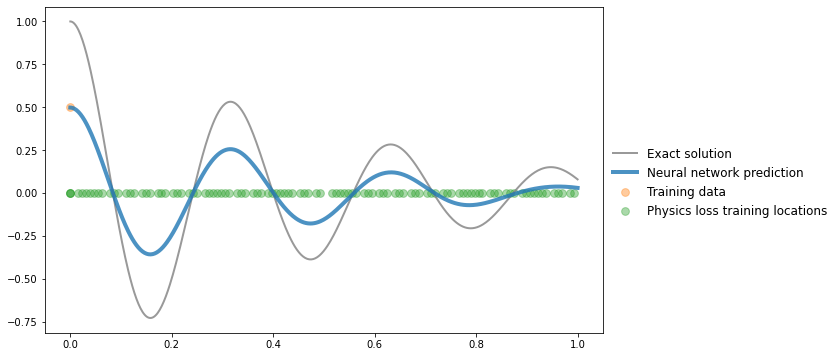

In [78]:
x_train_data = x_all_data[0:200:200]  # 错误的中间数据，带入微分方程有解，但是与原条件的解不匹配
y_train_data = y_all_data[0:200:200]*1/2

slove_pde(x_all_data, y_all_data, x_train_data, y_train_data, pde, func, sample_number=100)

G:\Anaconda3\envs\py3.8\lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+102=102. 
  warnings.warn("The balance properties of Sobol' points require "
G:\Anaconda3\envs\py3.8\lib\site-packages\keras\legacy_tf_layers\core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
G:\Anaconda3\envs\py3.8\lib\site-packages\keras\engine\base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Compiling model...
Building feed-forward neural network...
'build' took 2.344498 s

'compile' took 3.798468 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric   
0         [1.55e+03, 7.67e+03, 3.37e-02]    [1.56e+03, 7.67e+03, 3.37e-02]    [1.04e+00]    
1000      [7.97e+01, 7.41e+03, 1.05e-02]    [7.76e+01, 7.41e+03, 1.05e-02]    [1.01e+00]    
2000      [2.03e+02, 7.18e+03, 1.35e-01]    [1.94e+02, 7.18e+03, 1.35e-01]    [1.02e+00]    
3000      [3.22e+02, 6.43e+03, 5.82e-01]    [3.18e+02, 6.43e+03, 5.82e-01]    [9.81e-01]    
4000      [1.27e+03, 3.04e+03, 2.89e+01]    [1.27e+03, 3.04e+03, 2.89e+01]    [6.63e-01]    
5000      [9.36e+02, 6.63e+02, 3.09e+01]    [8.13e+02, 6.63e+02, 3.09e+01]    [4.43e-01]    
6000      [3.10e+02, 2.57e+01, 3.51e-02]    [3.28e+02, 2.57e+01, 3.51e-02]    [8.45e-01]    
7000      [1.73e+02, 1.02e+01, 2.94e-03]    [1.86e+02, 1.02e+01, 2.94e-03]    [8.90e-01]    
8000   

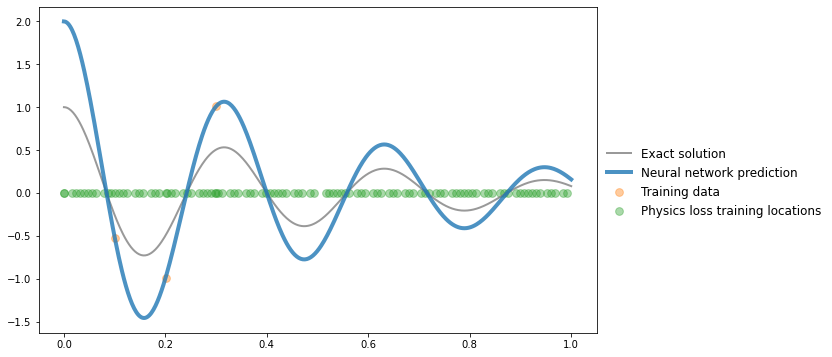

In [79]:
x_train_data = x_all_data[50:200:50]  # 错误的中间数据，带入微分方程有解，但是与原条件的解不匹配
y_train_data = y_all_data[50:200:50]*2

slove_pde(x_all_data, y_all_data, x_train_data, y_train_data, pde, func, sample_number=100)

Compiling model...
Building feed-forward neural network...
'build' took 0.059357 s



G:\Anaconda3\envs\py3.8\lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+102=102. 
  warnings.warn("The balance properties of Sobol' points require "
G:\Anaconda3\envs\py3.8\lib\site-packages\keras\legacy_tf_layers\core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
G:\Anaconda3\envs\py3.8\lib\site-packages\keras\engine\base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 1.488954 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric   
0         [9.79e+02, 4.87e+03, 2.18e-02]    [9.83e+02, 4.87e+03, 2.18e-02]    [1.02e+00]    
1000      [2.30e+01, 4.89e+03, 2.67e-04]    [2.27e+01, 4.89e+03, 2.67e-04]    [9.99e-01]    
2000      [2.33e+01, 4.89e+03, 3.94e-05]    [2.31e+01, 4.89e+03, 3.94e-05]    [9.99e-01]    
3000      [2.36e+01, 4.88e+03, 7.08e-04]    [2.35e+01, 4.88e+03, 7.08e-04]    [1.00e+00]    
4000      [1.15e+02, 4.69e+03, 7.41e-01]    [1.13e+02, 4.69e+03, 7.41e-01]    [1.02e+00]    
5000      [4.93e+02, 3.29e+03, 1.29e+01]    [5.01e+02, 3.29e+03, 1.29e+01]    [7.92e-01]    
6000      [4.94e+02, 2.38e+03, 6.54e+01]    [4.60e+02, 2.38e+03, 6.54e+01]    [5.42e-01]    
7000      [3.70e+02, 1.72e+03, 6.92e+01]    [3.83e+02, 1.72e+03, 6.92e+01]    [5.09e-01]    
8000      [3.51e+02, 1.64e+03, 6.10e+01]    [3.83e+02, 1.64e+03, 6.10e+01]    [6.01e-01]   

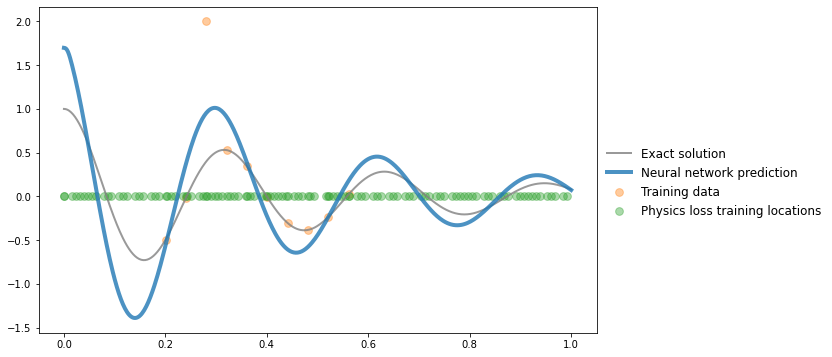

In [80]:
x_train_data = x_all_data[100:300:20]  # 错误的数据，带入微分方程无解,但是人类明显可以看出是异常值
y_train_data = y_all_data[100:300:20]*1
y_train_data[2] = 2.
slove_pde(x_all_data, y_all_data, x_train_data, y_train_data, pde, func, sample_number=100)

Compiling model...
Building feed-forward neural network...
'build' took 0.062571 s



G:\Anaconda3\envs\py3.8\lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+102=102. 
  warnings.warn("The balance properties of Sobol' points require "
G:\Anaconda3\envs\py3.8\lib\site-packages\keras\legacy_tf_layers\core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
G:\Anaconda3\envs\py3.8\lib\site-packages\keras\engine\base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 1.605296 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric   
0         [5.68e+03, 1.28e+03, 1.22e-01]    [5.71e+03, 1.28e+03, 1.22e-01]    [1.12e+00]    
1000      [7.04e-01, 9.76e+02, 4.14e-06]    [7.07e-01, 9.76e+02, 4.14e-06]    [1.00e+00]    
2000      [7.54e-01, 9.76e+02, 5.01e-05]    [7.62e-01, 9.76e+02, 5.01e-05]    [1.00e+00]    
3000      [8.97e-01, 9.76e+02, 1.45e-04]    [9.08e-01, 9.76e+02, 1.45e-04]    [1.00e+00]    
4000      [1.02e+00, 9.75e+02, 2.08e-04]    [1.03e+00, 9.75e+02, 2.08e-04]    [1.00e+00]    
5000      [1.05e+00, 9.75e+02, 2.03e-04]    [1.07e+00, 9.75e+02, 2.03e-04]    [1.00e+00]    
6000      [1.07e+00, 9.75e+02, 1.67e-04]    [1.08e+00, 9.75e+02, 1.67e-04]    [1.00e+00]    
7000      [1.09e+00, 9.75e+02, 1.04e-04]    [1.11e+00, 9.75e+02, 1.04e-04]    [1.00e+00]    
8000      [1.15e+00, 9.75e+02, 7.56e-06]    [1.18e+00, 9.75e+02, 7.56e-06]    [1.00e+00]   

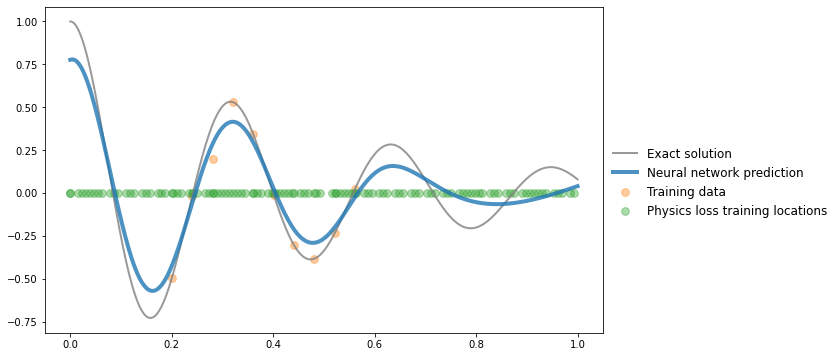

In [81]:
x_train_data = x_all_data[100:300:20]  # 错误的数据，带入微分方程无解,但是人类明显可以看出是异常值
y_train_data = y_all_data[100:300:20]*1
y_train_data[2] = 0.2
slove_pde(x_all_data, y_all_data, x_train_data, y_train_data, pde, func, sample_number=100)

Compiling model...
Building feed-forward neural network...
'build' took 0.063841 s



G:\Anaconda3\envs\py3.8\lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+102=102. 
  warnings.warn("The balance properties of Sobol' points require "
G:\Anaconda3\envs\py3.8\lib\site-packages\keras\legacy_tf_layers\core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
G:\Anaconda3\envs\py3.8\lib\site-packages\keras\engine\base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 1.612782 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric   
0         [3.15e+02, 1.26e+03, 5.36e-03]    [3.16e+02, 1.26e+03, 5.36e-03]    [1.01e+00]    
1000      [1.17e+01, 1.15e+03, 4.48e-04]    [1.18e+01, 1.15e+03, 4.48e-04]    [1.00e+00]    
2000      [1.42e+01, 1.15e+03, 1.96e-03]    [1.44e+01, 1.15e+03, 1.96e-03]    [9.99e-01]    
3000      [1.46e+01, 1.15e+03, 2.78e-03]    [1.48e+01, 1.15e+03, 2.78e-03]    [9.99e-01]    
4000      [1.47e+01, 1.15e+03, 4.93e-03]    [1.49e+01, 1.15e+03, 4.93e-03]    [9.99e-01]    
5000      [1.49e+01, 1.14e+03, 1.29e-02]    [1.50e+01, 1.14e+03, 1.29e-02]    [9.98e-01]    
6000      [1.50e+01, 1.14e+03, 1.80e-02]    [1.51e+01, 1.14e+03, 1.80e-02]    [9.97e-01]    
7000      [1.43e+01, 1.14e+03, 1.61e-02]    [1.43e+01, 1.14e+03, 1.61e-02]    [9.97e-01]    
8000      [1.54e+01, 1.14e+03, 1.41e-02]    [1.54e+01, 1.14e+03, 1.41e-02]    [9.98e-01]   

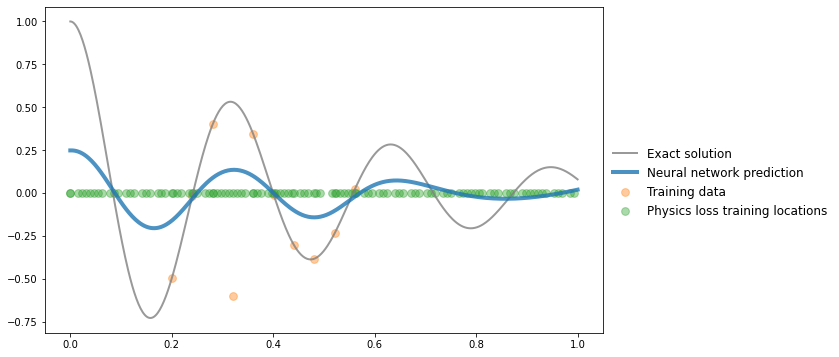

In [83]:
x_train_data = x_all_data[100:300:20]  # 错误的数据，带入微分方程无解,但是人类明显可以看出是异常值
y_train_data = y_all_data[100:300:20]*1
y_train_data[3] = -0.6
slove_pde(x_all_data, y_all_data, x_train_data, y_train_data, pde, func, sample_number=100)

Compiling model...
Building feed-forward neural network...
'build' took 0.062988 s



G:\Anaconda3\envs\py3.8\lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+102=102. 
  warnings.warn("The balance properties of Sobol' points require "
G:\Anaconda3\envs\py3.8\lib\site-packages\keras\legacy_tf_layers\core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
G:\Anaconda3\envs\py3.8\lib\site-packages\keras\engine\base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 4.590440 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric   
0         [5.97e+02, 1.60e+03, 1.40e-02]    [6.00e+02, 1.60e+03, 1.40e-02]    [1.02e+00]    
1000      [2.45e+01, 1.38e+03, 1.34e-04]    [2.43e+01, 1.38e+03, 1.34e-04]    [9.99e-01]    
2000      [3.14e+01, 1.37e+03, 4.02e-03]    [3.17e+01, 1.37e+03, 4.02e-03]    [1.00e+00]    
3000      [3.94e+01, 1.34e+03, 5.06e-02]    [3.96e+01, 1.34e+03, 5.06e-02]    [1.01e+00]    
4000      [6.04e+01, 1.30e+03, 1.62e-01]    [5.94e+01, 1.30e+03, 1.62e-01]    [1.01e+00]    
5000      [1.17e+02, 1.07e+03, 8.18e-01]    [1.17e+02, 1.07e+03, 8.18e-01]    [9.34e-01]    
6000      [2.42e+02, 7.48e+02, 6.27e+00]    [2.41e+02, 7.48e+02, 6.27e+00]    [8.19e-01]    
7000      [2.56e+02, 5.47e+02, 1.54e+01]    [2.43e+02, 5.47e+02, 1.54e+01]    [6.73e-01]    
8000      [2.07e+02, 3.58e+02, 1.55e+01]    [1.87e+02, 3.58e+02, 1.55e+01]    [4.53e-01]   

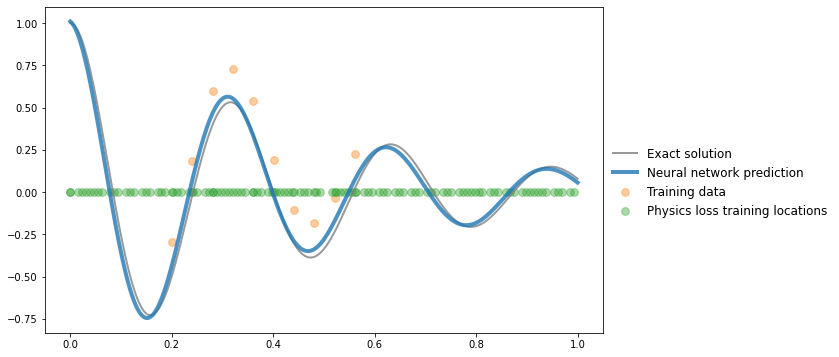

In [86]:
x_train_data = x_all_data[100:300:20]  # 错误的数据，全部向上偏移0.2
y_train_data = y_all_data[100:300:20]*1
y_train_data += 0.2
slove_pde(x_all_data, y_all_data, x_train_data, y_train_data, pde, func, sample_number=100)

Compiling model...
Building feed-forward neural network...
'build' took 0.064615 s



G:\Anaconda3\envs\py3.8\lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+102=102. 
  warnings.warn("The balance properties of Sobol' points require "
G:\Anaconda3\envs\py3.8\lib\site-packages\keras\legacy_tf_layers\core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
G:\Anaconda3\envs\py3.8\lib\site-packages\keras\engine\base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 1.690570 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric   
0         [1.01e+04, 1.44e+04, 2.15e-01]    [1.01e+04, 1.44e+04, 2.15e-01]    [1.22e+00]    
1000      [6.31e+02, 9.45e+03, 3.97e-03]    [6.27e+02, 9.45e+03, 3.97e-03]    [1.01e+00]    
2000      [7.02e+02, 9.14e+03, 3.96e-02]    [7.06e+02, 9.14e+03, 3.96e-02]    [1.02e+00]    
3000      [1.04e+03, 8.58e+03, 8.62e-01]    [1.05e+03, 8.58e+03, 8.62e-01]    [1.05e+00]    
4000      [1.08e+03, 8.48e+03, 1.68e+00]    [1.08e+03, 8.48e+03, 1.68e+00]    [1.06e+00]    
5000      [1.11e+03, 8.36e+03, 1.46e+00]    [1.11e+03, 8.36e+03, 1.46e+00]    [1.07e+00]    
6000      [1.30e+03, 7.86e+03, 1.20e+00]    [1.28e+03, 7.86e+03, 1.20e+00]    [1.02e+00]    
7000      [1.41e+03, 7.43e+03, 2.19e+01]    [1.38e+03, 7.43e+03, 2.19e+01]    [9.05e-01]    
8000      [1.46e+03, 7.31e+03, 3.43e+01]    [1.42e+03, 7.31e+03, 3.43e+01]    [8.61e-01]   

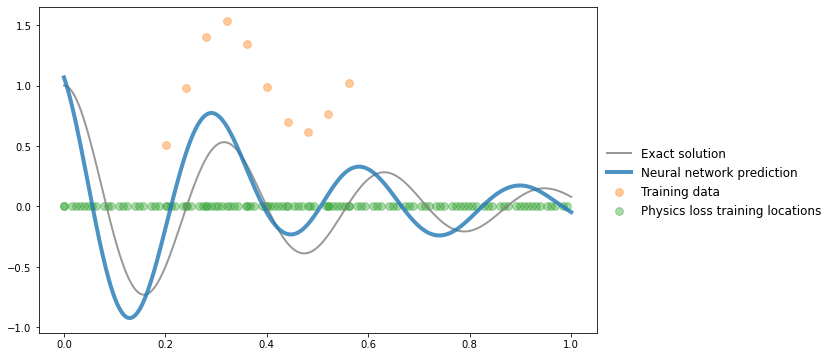

In [87]:
x_train_data = x_all_data[100:300:20]  # 错误的数据，向上偏移1
y_train_data = y_all_data[100:300:20]*1
y_train_data += 1
slove_pde(x_all_data, y_all_data, x_train_data, y_train_data, pde, func, sample_number=100)

Compiling model...
Building feed-forward neural network...
'build' took 0.066916 s



G:\Anaconda3\envs\py3.8\lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+102=102. 
  warnings.warn("The balance properties of Sobol' points require "
G:\Anaconda3\envs\py3.8\lib\site-packages\keras\legacy_tf_layers\core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
G:\Anaconda3\envs\py3.8\lib\site-packages\keras\engine\base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 1.729604 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric   
0         [9.50e+02, 4.17e+03, 1.74e-02]    [9.53e+02, 4.17e+03, 1.74e-02]    [1.02e+00]    
1000      [1.28e+02, 3.73e+03, 2.02e-02]    [1.25e+02, 3.73e+03, 2.02e-02]    [9.94e-01]    
2000      [1.53e+02, 3.69e+03, 1.10e-01]    [1.45e+02, 3.69e+03, 1.10e-01]    [9.89e-01]    
3000      [2.14e+02, 3.51e+03, 1.74e+00]    [1.94e+02, 3.51e+03, 1.74e+00]    [9.65e-01]    
4000      [6.00e+02, 1.80e+03, 4.32e+00]    [5.73e+02, 1.80e+03, 4.32e+00]    [7.26e-01]    
5000      [5.22e+02, 7.27e+02, 5.60e-02]    [4.97e+02, 7.27e+02, 5.60e-02]    [5.02e-01]    
6000      [3.93e+02, 3.91e+02, 1.78e+00]    [3.85e+02, 3.91e+02, 1.78e+00]    [3.81e-01]    
7000      [1.96e+02, 2.84e+02, 2.42e+00]    [1.97e+02, 2.84e+02, 2.42e+00]    [2.31e-01]    
8000      [1.73e+02, 2.72e+02, 2.59e+00]    [1.79e+02, 2.72e+02, 2.59e+00]    [2.01e-01]   

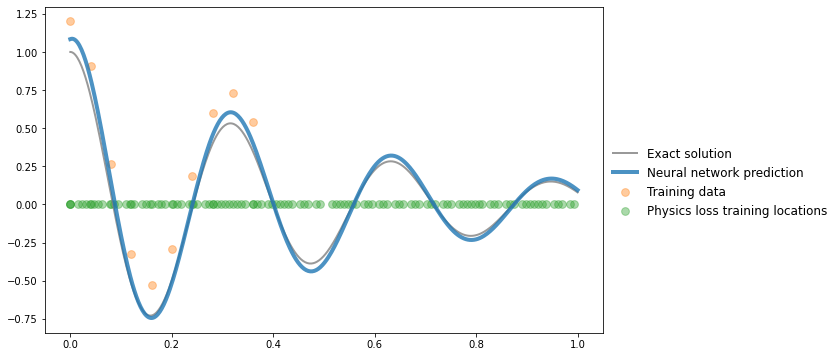

In [89]:
x_train_data = x_all_data[0:200:20]  # 错误的初始数据，向上偏移0.2
y_train_data = y_all_data[0:200:20]*1
y_train_data += 0.2
slove_pde(x_all_data, y_all_data, x_train_data, y_train_data, pde, func, sample_number=100)

Compiling model...
Building feed-forward neural network...
'build' took 0.063902 s



G:\Anaconda3\envs\py3.8\lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+102=102. 
  warnings.warn("The balance properties of Sobol' points require "
G:\Anaconda3\envs\py3.8\lib\site-packages\keras\legacy_tf_layers\core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
G:\Anaconda3\envs\py3.8\lib\site-packages\keras\engine\base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 1.704687 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric   
0         [1.41e+04, 1.37e+04, 3.07e-01]    [1.42e+04, 1.37e+04, 3.07e-01]    [1.27e+00]    
1000      [1.41e+03, 1.26e+04, 7.30e-02]    [1.38e+03, 1.26e+04, 7.30e-02]    [1.01e+00]    
2000      [1.45e+03, 1.25e+04, 2.11e-01]    [1.40e+03, 1.25e+04, 2.11e-01]    [1.01e+00]    
3000      [1.49e+03, 1.24e+04, 3.03e-01]    [1.44e+03, 1.24e+04, 3.03e-01]    [1.00e+00]    
4000      [1.50e+03, 1.24e+04, 2.81e-01]    [1.45e+03, 1.24e+04, 2.81e-01]    [1.00e+00]    
5000      [1.50e+03, 1.24e+04, 2.58e-01]    [1.45e+03, 1.24e+04, 2.58e-01]    [1.00e+00]    
6000      [1.50e+03, 1.24e+04, 2.36e-01]    [1.45e+03, 1.24e+04, 2.36e-01]    [1.01e+00]    
7000      [1.50e+03, 1.24e+04, 2.21e-01]    [1.45e+03, 1.24e+04, 2.21e-01]    [1.01e+00]    
8000      [1.50e+03, 1.24e+04, 2.17e-01]    [1.45e+03, 1.24e+04, 2.17e-01]    [1.01e+00]   

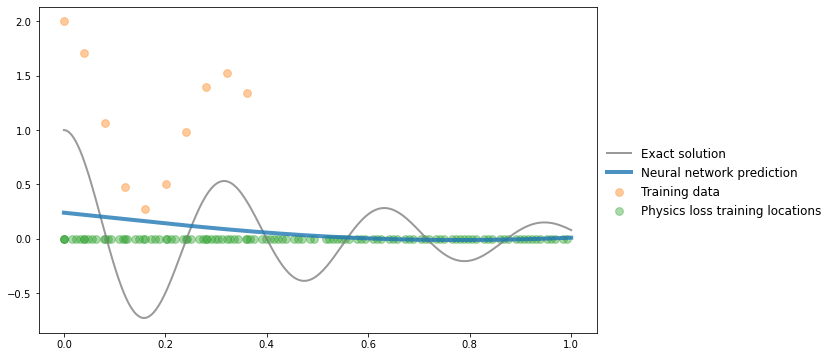

In [88]:
x_train_data = x_all_data[0:200:20]  # 错误的初始数据，向上偏移1
y_train_data = y_all_data[0:200:20]*1
y_train_data += 1
slove_pde(x_all_data, y_all_data, x_train_data, y_train_data, pde, func, sample_number=100)

Compiling model...
Building feed-forward neural network...
'build' took 0.067311 s



G:\Anaconda3\envs\py3.8\lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+102=102. 
  warnings.warn("The balance properties of Sobol' points require "
G:\Anaconda3\envs\py3.8\lib\site-packages\keras\legacy_tf_layers\core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
G:\Anaconda3\envs\py3.8\lib\site-packages\keras\engine\base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 1.787629 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric   
0         [1.05e+04, 3.08e+03, 2.46e-01]    [1.05e+04, 3.08e+03, 2.46e-01]    [1.22e+00]    
1000      [1.27e+01, 3.09e+03, 3.63e-04]    [1.25e+01, 3.09e+03, 3.63e-04]    [9.99e-01]    
2000      [1.27e+01, 3.09e+03, 3.31e-04]    [1.25e+01, 3.09e+03, 3.31e-04]    [9.99e-01]    
3000      [1.27e+01, 3.09e+03, 3.02e-04]    [1.25e+01, 3.09e+03, 3.02e-04]    [9.99e-01]    
4000      [1.27e+01, 3.09e+03, 2.85e-04]    [1.25e+01, 3.09e+03, 2.85e-04]    [9.99e-01]    
5000      [1.27e+01, 3.09e+03, 2.76e-04]    [1.25e+01, 3.09e+03, 2.76e-04]    [9.99e-01]    
6000      [1.27e+01, 3.09e+03, 2.68e-04]    [1.25e+01, 3.09e+03, 2.68e-04]    [9.99e-01]    
7000      [1.27e+01, 3.09e+03, 2.54e-04]    [1.25e+01, 3.09e+03, 2.54e-04]    [9.99e-01]    
8000      [1.27e+01, 3.09e+03, 2.32e-04]    [1.25e+01, 3.09e+03, 2.32e-04]    [9.99e-01]   

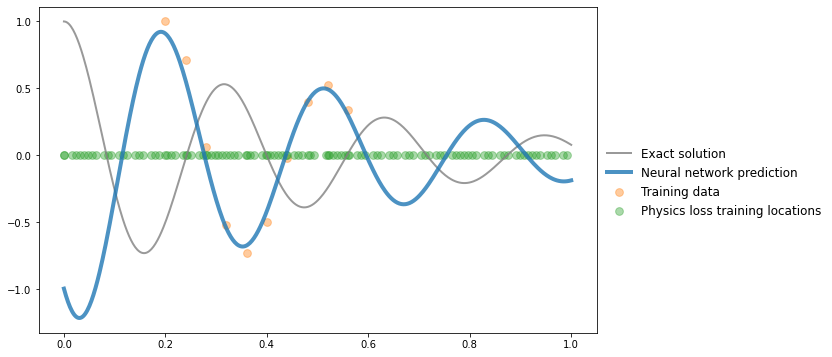

In [92]:
x_train_data = x_all_data[0:200:20]*1  # 错误的数据，x向右偏移0.2
y_train_data = y_all_data[0:200:20]
x_train_data += 0.2
slove_pde(x_all_data, y_all_data, x_train_data, y_train_data, pde, func, sample_number=100)

Compiling model...
Building feed-forward neural network...
'build' took 0.064956 s



G:\Anaconda3\envs\py3.8\lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+102=102. 
  warnings.warn("The balance properties of Sobol' points require "
G:\Anaconda3\envs\py3.8\lib\site-packages\keras\legacy_tf_layers\core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
G:\Anaconda3\envs\py3.8\lib\site-packages\keras\engine\base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 1.940720 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric   
0         [1.25e+03, 3.15e+03, 2.42e-02]    [1.25e+03, 3.15e+03, 2.42e-02]    [1.02e+00]    
1000      [3.13e+01, 3.01e+03, 1.10e-02]    [3.01e+01, 3.01e+03, 1.10e-02]    [9.98e-01]    
2000      [5.40e+01, 2.90e+03, 1.36e-01]    [5.08e+01, 2.90e+03, 1.36e-01]    [9.95e-01]    
3000      [4.86e+01, 1.59e+03, 8.92e-02]    [4.59e+01, 1.59e+03, 8.92e-02]    [1.05e+00]    
4000      [2.76e+02, 6.23e+02, 2.07e+01]    [2.59e+02, 6.23e+02, 2.07e+01]    [1.11e+00]    
5000      [2.91e+02, 3.95e+02, 3.17e+01]    [2.82e+02, 3.95e+02, 3.17e+01]    [1.16e+00]    
6000      [2.73e+02, 2.05e+02, 3.46e+01]    [2.75e+02, 2.05e+02, 3.46e+01]    [1.23e+00]    
7000      [2.17e+02, 1.30e+02, 3.70e+01]    [2.17e+02, 1.30e+02, 3.70e+01]    [1.27e+00]    
8000      [1.63e+02, 7.76e+01, 4.40e+01]    [1.67e+02, 7.76e+01, 4.40e+01]    [1.32e+00]   

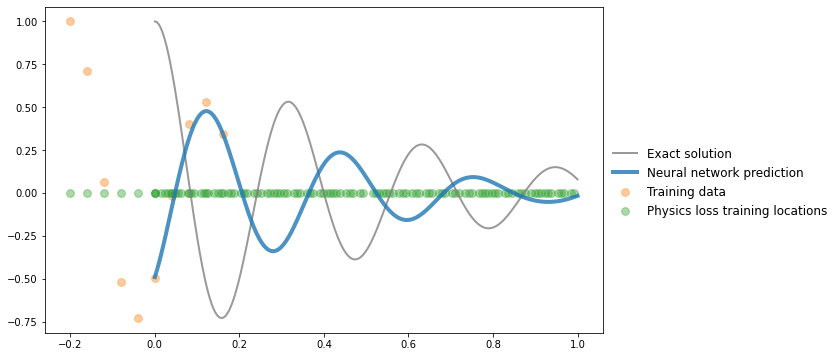

In [93]:
x_train_data = x_all_data[0:200:20]*1  # 错误的数据，x向左偏移0.2
y_train_data = y_all_data[0:200:20]
x_train_data -= 0.2
slove_pde(x_all_data, y_all_data, x_train_data, y_train_data, pde, func, sample_number=100)

### 原问题域(0,1) 变大变小

In [117]:
def slove_pde(x_train_data, y_train_data, pde, func, sample_number:int=30, scale:float=1.):
    geom = dde.geometry.TimeDomain(0., scale)
    # ic_1 = dde.icbc.initial_conditions.IC(geom, lambda x: 1., boundary, component=0) # 初值条件 x(0) = 1.
    observe_y = dde.icbc.boundary_conditions.PointSetBC(points=x_train_data, values=y_train_data, component=0)
    ic_2 = dde.icbc.boundary_conditions.NeumannBC(geom, lambda x: 0.*x, boundary, component=0) # 导数条件 dx(0)/dt = 0

    data = dde.data.PDE(geom, pde, [observe_y, ic_2], int(sample_number*scale), 1, solution=func, num_test=int(500*scale))
    if scale>1:
        layer_size = [1] + [100] * 3 + [1]
    else:
        layer_size = [1] + [32] * 3 + [1]
    activation = "tanh"
    initializer = "Glorot uniform"
    net = dde.nn.FNN(layer_size, activation, initializer)
    model = dde.Model(data, net)
    model.compile("adam", lr=1e-4, metrics=["l2 relative error"],loss_weights = [1, 1e4, 1])
    losshistory, train_state = model.train(epochs=20000)
    if scale>1:
        model.compile("adam", lr=1e-5, metrics=["l2 relative error"],loss_weights = [1, 1e5, 1])
        losshistory, train_state = model.train(epochs=20000)
        x_all_data = np.linspace(0,scale,int(500*scale)).reshape(-1,1)
    else:
        x_all_data = np.linspace(0,1,int(500)).reshape(-1,1)
    y_all_data = func(x_all_data)
    pred_data = model.predict(x_all_data)
    residual_points = sorted(data.train_next_batch()[0])# residual_points, sample_points
    plot_result(x_all_data,y_all_data,x_train_data,y_train_data,pred_data, residual_points)
    


Compiling model...
Building feed-forward neural network...
'build' took 0.077371 s



G:\Anaconda3\envs\py3.8\lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+42=42. 
  warnings.warn("The balance properties of Sobol' points require "
G:\Anaconda3\envs\py3.8\lib\site-packages\keras\legacy_tf_layers\core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
G:\Anaconda3\envs\py3.8\lib\site-packages\keras\engine\base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 2.170011 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric   
0         [6.09e+02, 1.00e+04, 6.77e-02]    [6.36e+02, 1.00e+04, 6.77e-02]    [9.90e-01]    
1000      [1.60e+03, 6.06e+03, 1.16e+00]    [1.47e+03, 6.06e+03, 1.16e+00]    [9.87e-01]    
2000      [1.95e+03, 1.86e+03, 1.37e+01]    [1.84e+03, 1.86e+03, 1.37e+01]    [6.88e-01]    
3000      [7.84e+02, 2.91e+02, 4.10e+01]    [8.09e+02, 2.91e+02, 4.10e+01]    [3.98e-01]    
4000      [5.63e+01, 2.02e+00, 3.17e+00]    [8.52e+01, 2.02e+00, 3.17e+00]    [8.39e-02]    
5000      [1.13e+01, 8.54e-02, 4.38e-02]    [2.45e+01, 8.54e-02, 4.38e-02]    [1.03e-02]    
6000      [4.14e+00, 2.00e-03, 1.30e-01]    [1.14e+01, 2.00e-03, 1.30e-01]    [1.68e-02]    
7000      [1.59e+00, 7.86e-04, 4.04e-02]    [5.51e+00, 7.86e-04, 4.04e-02]    [8.81e-03]    
8000      [9.18e-01, 1.08e-05, 9.20e-03]    [3.32e+00, 1.08e-05, 9.20e-03]    [3.63e-03]   

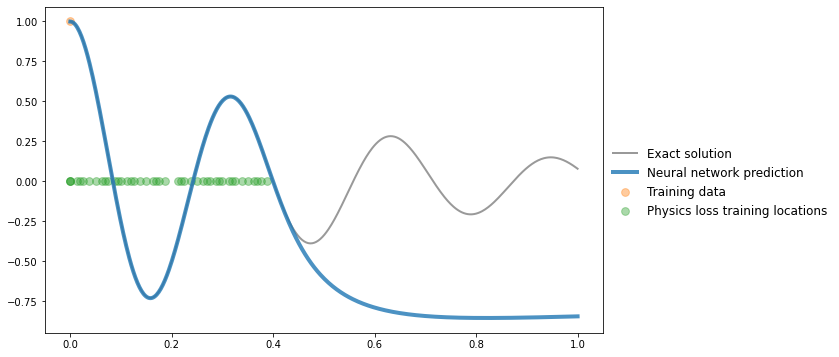

In [106]:
x_train_data = x_all_data[0:200:200]  # [0,0.4]
y_train_data = y_all_data[0:200:200]
slove_pde(x_train_data, y_train_data, pde, func, sample_number=100, scale=0.4)

Compiling model...
Building feed-forward neural network...
'build' took 0.078154 s



G:\Anaconda3\envs\py3.8\lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+202=202. 
  warnings.warn("The balance properties of Sobol' points require "
G:\Anaconda3\envs\py3.8\lib\site-packages\keras\legacy_tf_layers\core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
G:\Anaconda3\envs\py3.8\lib\site-packages\keras\engine\base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 2.381794 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric   
0         [1.12e+04, 1.00e+04, 5.60e-02]    [1.13e+04, 1.00e+04, 5.60e-02]    [1.43e+00]    
1000      [2.03e+03, 1.68e+03, 1.02e+01]    [1.86e+03, 1.68e+03, 1.02e+01]    [9.77e-01]    
2000      [8.89e+02, 1.89e+02, 2.33e+01]    [8.51e+02, 1.89e+02, 2.33e+01]    [7.32e-01]    
3000      [7.77e+02, 1.09e+02, 1.61e+01]    [7.67e+02, 1.09e+02, 1.61e+01]    [6.95e-01]    
4000      [5.85e+02, 6.47e+01, 4.08e+00]    [5.73e+02, 6.47e+01, 4.08e+00]    [6.54e-01]    
5000      [3.93e+02, 2.70e+01, 2.37e+00]    [3.95e+02, 2.70e+01, 2.37e+00]    [5.78e-01]    
6000      [2.43e+02, 7.89e+00, 6.36e-01]    [2.44e+02, 7.89e+00, 6.36e-01]    [4.76e-01]    
7000      [1.81e+02, 4.31e+00, 1.59e-01]    [1.76e+02, 4.31e+00, 1.59e-01]    [4.22e-01]    
8000      [1.32e+02, 2.17e+00, 8.86e-02]    [1.29e+02, 2.17e+00, 8.86e-02]    [3.69e-01]   

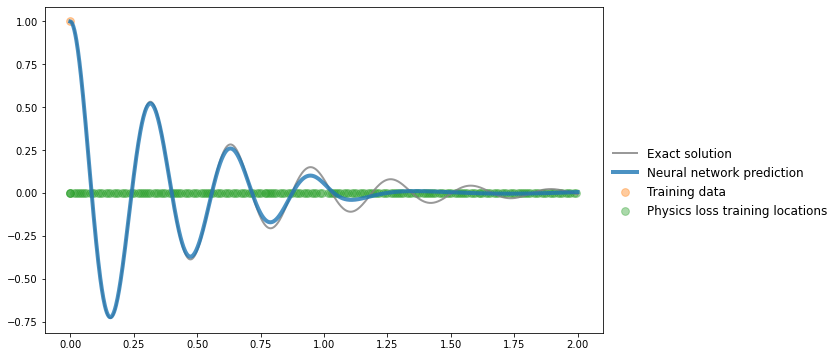

In [118]:
x_train_data = x_all_data[0:200:200]  # [0,2.]
y_train_data = y_all_data[0:200:200]
slove_pde(x_train_data, y_train_data, pde, func, sample_number=100, scale=2.)

Compiling model...
Building feed-forward neural network...
'build' took 0.078638 s



G:\Anaconda3\envs\py3.8\lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+1002=1002. 
  warnings.warn("The balance properties of Sobol' points require "
G:\Anaconda3\envs\py3.8\lib\site-packages\keras\legacy_tf_layers\core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
G:\Anaconda3\envs\py3.8\lib\site-packages\keras\engine\base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 2.357168 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric   
0         [6.01e+04, 1.00e+04, 3.38e-02]    [6.01e+04, 1.00e+04, 3.38e-02]    [5.40e+00]    
1000      [1.66e+03, 7.76e+02, 1.83e+00]    [1.66e+03, 7.76e+02, 1.83e+00]    [1.28e+00]    
2000      [1.01e+03, 1.96e+02, 1.43e+01]    [1.02e+03, 1.96e+02, 1.43e+01]    [1.10e+00]    
3000      [7.34e+02, 8.61e+01, 3.82e+01]    [7.49e+02, 8.61e+01, 3.82e+01]    [9.85e-01]    
4000      [5.87e+02, 4.92e+01, 5.60e+01]    [6.02e+02, 4.92e+01, 5.60e+01]    [9.12e-01]    
5000      [4.09e+02, 2.72e+01, 4.18e+01]    [4.17e+02, 2.72e+01, 4.18e+01]    [8.34e-01]    
6000      [2.26e+02, 9.67e+00, 2.76e+01]    [2.24e+02, 9.67e+00, 2.76e+01]    [7.08e-01]    
7000      [1.86e+02, 5.25e+00, 1.78e+01]    [1.78e+02, 5.25e+00, 1.78e+01]    [6.59e-01]    
8000      [1.40e+02, 3.47e+00, 1.06e+01]    [1.33e+02, 3.47e+00, 1.06e+01]    [6.19e-01]   

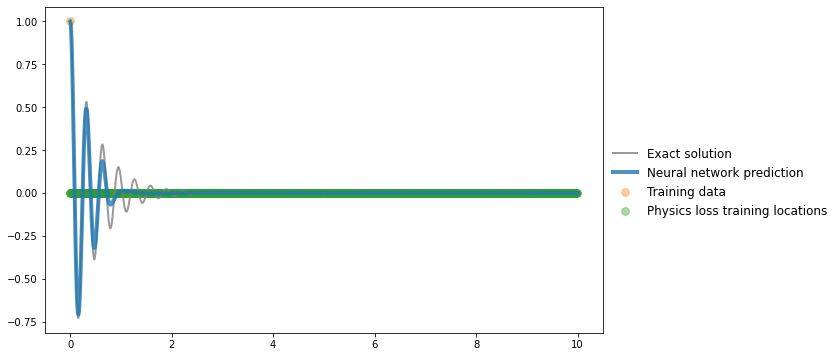

In [120]:
x_train_data = x_all_data[0:200:200]  # [0,10.]
y_train_data = y_all_data[0:200:200]
slove_pde(x_train_data, y_train_data, pde, func, sample_number=100, scale=10.)